# 17. Limited Dependent Variable Models and Sample Selection Corrections

:::{important} Learning Objectives
:class: dropdown
By the end of this chapter, you should be able to:

**17.1** Estimate and interpret logit and probit models for binary response variables.

**17.2** Apply fractional response models when the outcome is a proportion or percentage.

**17.3** Use exponential mean models and Poisson regression for count data.

**17.4** Estimate Tobit models for corner solution responses (e.g., hours worked, charitable contributions).

**17.5** Distinguish between censored and truncated regression models and estimate them appropriately.

**17.6** Apply Heckman's two-step procedure to correct for sample selection bias.
:::

Limited dependent variable models address a fundamental challenge in applied econometrics: many economic outcomes exhibit restricted ranges, discreteness, or censoring patterns that violate the assumptions underlying linear regression. This chapter develops specialized estimation methods for binary, fractional, count, corner solution, and censored outcomes, establishing how maximum likelihood and related techniques provide consistent and efficient estimates while respecting the inherent constraints on dependent variables.

The presentation progresses systematically through the taxonomy of limited dependent variables. We begin with binary response models including logit and probit specifications, establishing maximum likelihood estimation and interpretation of marginal effects (Section 17.1), extend to fractional response models for proportions and percentages using quasi-maximum likelihood (Section 17.2), develop Poisson and negative binomial models for count data with applications to patent counts and arrest frequencies (Section 17.3), examine Tobit models for corner solution responses where many observations cluster at boundary values (Section 17.4), distinguish between censored and truncated regression models with different missing data mechanisms (Section 17.5), and conclude with Heckman's selection correction procedure that addresses sample selection bias when outcomes are observed non-randomly (Section 17.6). Throughout, we implement methods using Python's statsmodels library and demonstrate applications to labor supply, program participation, innovation, and wage determination with selection.

In [1]:
# %pip install matplotlib numpy pandas statsmodels wooldridge scipy patsy -q

In [2]:
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy as pt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import wooldridge as wool
from IPython.display import display
from scipy import stats
from statsmodels.base.model import GenericLikelihoodModel

# Set plotting style
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["font.size"] = 11
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

## 17.1 Logit and Probit Models for Binary Response

When the outcome is **binary** (0 or 1), we model the **probability** of the outcome being 1:

$$ P(y = 1 | \mathbf{x}) = G(\beta_0 + \beta_1 x_1 + \cdots + \beta_k x_k) = G(\mathbf{x}'\boldsymbol{\beta}) $$

where $G(\cdot)$ is a **cumulative distribution function (CDF)** that ensures $0 \leq P(y=1|\mathbf{x}) \leq 1$.

### Three Approaches

1. **Linear Probability Model (LPM)**: $G(z) = z$ (just use OLS)
   - YES Simple, easy to interpret
   - NO Can predict outside [0, 1]
   - NO Heteroskedasticity by construction

2. **Logit Model**: $G(z) = \frac{e^z}{1 + e^z} = \Lambda(z)$ (logistic CDF)
   - YES Always predicts probabilities in [0, 1]
   - YES Closed-form derivatives
   - Assumes **logistic** error distribution

3. **Probit Model**: $G(z) = \Phi(z)$ (standard normal CDF)
   - YES Always predicts probabilities in [0, 1]
   - YES Based on **latent variable** interpretation
   - Assumes **normal** error distribution

### Latent Variable Interpretation

Think of an **unobserved** continuous variable $y^*$ (e.g., "propensity to work"):

$$ y^* = \mathbf{x}'\boldsymbol{\beta} + u $$

We observe:

$$ y = \begin{cases} 1 & \text{if } y^* > 0 \\ 0 & \text{if } y^* \leq 0 \end{cases} $$

Then:

$$ P(y = 1 | \mathbf{x}) = P(y^* > 0 | \mathbf{x}) = P(u > -\mathbf{x}'\boldsymbol{\beta} | \mathbf{x}) = G(\mathbf{x}'\boldsymbol{\beta}) $$

- **Logit**: $u$ follows logistic distribution
- **Probit**: $u \sim N(0, 1)$

### Estimation

Both models are estimated by **maximum likelihood**:

$$ \mathcal{L}(\boldsymbol{\beta}) = \prod_{i=1}^n [G(\mathbf{x}_i'\boldsymbol{\beta})]^{y_i} [1 - G(\mathbf{x}_i'\boldsymbol{\beta})]^{1-y_i} $$

Log likelihood:

$$ \ell(\boldsymbol{\beta}) = \sum_{i=1}^n \left\{ y_i \log G(\mathbf{x}_i'\boldsymbol{\beta}) + (1-y_i) \log[1 - G(\mathbf{x}_i'\boldsymbol{\beta})] \right\} $$

### Example 17.1: Married Women's Labor Force Participation

Let's estimate the probability that a married woman is in the labor force as a function of her characteristics.

In [3]:
# Load married women's labor force participation data
mroz = wool.data("mroz")

print("MARRIED WOMEN'S LABOR FORCE PARTICIPATION")
print("=" * 70)
print(f"\nTotal observations: {len(mroz)}")
print(f"Women in labor force (inlf=1): {mroz['inlf'].sum()}")
print(f"Women not in labor force (inlf=0): {(1 - mroz['inlf']).sum()}")
print(f"Participation rate: {mroz['inlf'].mean():.1%}")

print("\nDEPENDENT VARIABLE:")
print("  inlf = 1 if woman worked for a wage in 1975, 0 otherwise")

print("\nEXPLANATORY VARIABLES:")
print("  nwifeinc  = husband's income (thousands)")
print("  educ      = years of education")
print("  exper     = actual labor market experience (years)")
print("  age       = age in years")
print("  kidslt6   = number of children less than 6 years old")
print("  kidsge6   = number of children 6-18 years old")

# Summary statistics
key_vars = ["inlf", "nwifeinc", "educ", "exper", "age", "kidslt6", "kidsge6"]
display(mroz[key_vars].describe().round(2))

MARRIED WOMEN'S LABOR FORCE PARTICIPATION

Total observations: 753
Women in labor force (inlf=1): 428
Women not in labor force (inlf=0): 325
Participation rate: 56.8%

DEPENDENT VARIABLE:
  inlf = 1 if woman worked for a wage in 1975, 0 otherwise

EXPLANATORY VARIABLES:
  nwifeinc  = husband's income (thousands)
  educ      = years of education
  exper     = actual labor market experience (years)
  age       = age in years
  kidslt6   = number of children less than 6 years old
  kidsge6   = number of children 6-18 years old


,inlf,nwifeinc,educ,exper,age,kidslt6,kidsge6
count,753.00,753.00,753.00,753.00,753.00,753.00,753.00
mean,0.57,20.13,12.29,10.63,42.54,0.24,1.35
std,0.50,11.63,2.28,8.07,8.07,0.52,1.32
min,0.00,-0.03,5.00,0.00,30.00,0.00,0.00
25%,0.00,13.03,12.00,4.00,36.00,0.00,0.00
50%,1.00,17.70,12.00,9.00,43.00,0.00,1.00
75%,1.00,24.47,13.00,15.00,49.00,0.00,2.00
max,1.00,96.00,17.00,45.00,60.00,3.00,8.00


In [4]:
# LINEAR PROBABILITY MODEL (LPM)
print("\n17.1.1 LINEAR PROBABILITY MODEL (OLS)")
print("=" * 70)
print("Model: P(inlf=1) = beta_0 + beta_1*nwifeinc + beta_2*educ + ... + u")
print("Uses OLS but with heteroskedasticity-robust standard errors (HC3)")

lpm = smf.ols(
    formula="inlf ~ nwifeinc + educ + exper + I(exper**2) + age + kidslt6 + kidsge6",
    data=mroz,
).fit(cov_type="HC3")

table_lpm = pd.DataFrame(
    {
        "Coefficient": lpm.params,
        "Std. Error": lpm.bse,
        "t-statistic": lpm.tvalues,
        "p-value": lpm.pvalues,
    },
)

print("\nLINEAR PROBABILITY MODEL RESULTS:")
display(table_lpm.round(4))

print(f"\nR-squared: {lpm.rsquared:.4f}")
print(f"Observations: {lpm.nobs:.0f}")

print("\nINTERPRETATION (coefficients are marginal effects):")
print(f"  nwifeinc: {lpm.params['nwifeinc']:.4f}")
print(
    f"    -> $1,000 increase in husband's income -> {100 * lpm.params['nwifeinc']:.2f} percentage point decrease in participation"
)
print(f"  educ: {lpm.params['educ']:.4f}")
print(
    f"    -> 1 more year of education -> {100 * lpm.params['educ']:.2f} percentage point increase in participation"
)
print(f"  kidslt6: {lpm.params['kidslt6']:.4f}")
print(
    f"    -> 1 more young child -> {100 * lpm.params['kidslt6']:.2f} percentage point decrease in participation"
)


17.1.1 LINEAR PROBABILITY MODEL (OLS)
Model: P(inlf=1) = beta_0 + beta_1*nwifeinc + beta_2*educ + ... + u
Uses OLS but with heteroskedasticity-robust standard errors (HC3)

LINEAR PROBABILITY MODEL RESULTS:


,Coefficient,Std. Error,t-statistic,p-value
Intercept,0.5855,0.1536,3.8125,0.0001
nwifeinc,-0.0034,0.0016,-2.1852,0.0289
educ,0.0380,0.0073,5.1766,0.0000
exper,0.0395,0.0060,6.6001,0.0000
I(exper ** 2),-0.0006,0.0002,-2.9973,0.0027
age,-0.0161,0.0024,-6.6640,0.0000
kidslt6,-0.2618,0.0322,-8.1430,0.0000
kidsge6,0.0130,0.0137,0.9526,0.3408



R-squared: 0.2642
Observations: 753

INTERPRETATION (coefficients are marginal effects):
  nwifeinc: -0.0034
    -> $1,000 increase in husband's income -> -0.34 percentage point decrease in participation
  educ: 0.0380
    -> 1 more year of education -> 3.80 percentage point increase in participation
  kidslt6: -0.2618
    -> 1 more young child -> -26.18 percentage point decrease in participation


In [5]:
# Check LPM predictions - some may be outside [0, 1]
print("\nPROBLEM WITH LPM: Predictions can be outside [0, 1]")
print("=" * 70)

lpm_predictions = lpm.predict(mroz)
print(f"Minimum prediction: {lpm_predictions.min():.4f}")
print(f"Maximum prediction: {lpm_predictions.max():.4f}")

n_below_zero = (lpm_predictions < 0).sum()
n_above_one = (lpm_predictions > 1).sum()

print(f"\nPredictions < 0: {n_below_zero} ({100 * n_below_zero / len(mroz):.1f}%)")
print(f"Predictions > 1: {n_above_one} ({100 * n_above_one / len(mroz):.1f}%)")

if n_below_zero > 0 or n_above_one > 0:
    print("\nNO LPM produces invalid probabilities!")
    print("  -> Need logit or probit to constrain predictions to [0, 1]")


PROBLEM WITH LPM: Predictions can be outside [0, 1]
Minimum prediction: -0.3451
Maximum prediction: 1.1272

Predictions < 0: 16 (2.1%)
Predictions > 1: 17 (2.3%)

NO LPM produces invalid probabilities!
  -> Need logit or probit to constrain predictions to [0, 1]


In [6]:
# Extreme predictions with LPM
print("\nEXTREME CASE PREDICTIONS (LPM)")
print("=" * 70)

# Two "extreme" women
X_extreme = pd.DataFrame(
    {
        "nwifeinc": [100, 0],  # High vs low husband income
        "educ": [5, 17],  # Low vs high education
        "exper": [0, 30],  # No experience vs lots
        "age": [20, 52],  # Young vs older
        "kidslt6": [2, 0],  # Young children vs none
        "kidsge6": [0, 0],  # No older children
    },
)

predictions_lpm = lpm.predict(X_extreme)

print("Woman 1: Low education, high husband income, young children")
print(f"  Predicted P(inlf=1) = {predictions_lpm.iloc[0]:.4f}")

print("\nWoman 2: High education, low husband income, no young children")
print(f"  Predicted P(inlf=1) = {predictions_lpm.iloc[1]:.4f}")

if predictions_lpm.iloc[0] < 0:
    print(f"\nNO Woman 1: Negative probability! ({predictions_lpm.iloc[0]:.4f})")
if predictions_lpm.iloc[1] > 1:
    print(f"NO Woman 2: Probability > 1! ({predictions_lpm.iloc[1]:.4f})")


EXTREME CASE PREDICTIONS (LPM)
Woman 1: Low education, high husband income, young children
  Predicted P(inlf=1) = -0.4105

Woman 2: High education, low husband income, no young children
  Predicted P(inlf=1) = 1.0428

NO Woman 1: Negative probability! (-0.4105)
NO Woman 2: Probability > 1! (1.0428)


In [7]:
# LOGIT MODEL
print("\n\n17.1.3 LOGIT MODEL")
print("=" * 70)
print("Model: P(inlf=1) = Lambda(beta_0 + beta_1*nwifeinc + beta_2*educ + ...)")
print("where Lambda(z) = exp(z) / [1 + exp(z)] is the logistic CDF")

logit = smf.logit(
    formula="inlf ~ nwifeinc + educ + exper + I(exper**2) + age + kidslt6 + kidsge6",
    data=mroz,
).fit(disp=0)

print("\nLOGIT MODEL RESULTS:")
print(logit.summary())

print(f"\nLog-Likelihood: {logit.llf:.4f}")
print(f"McFadden's Pseudo R^2: {logit.prsquared:.4f}")
print(f"AIC: {logit.aic:.4f}")



17.1.3 LOGIT MODEL
Model: P(inlf=1) = Lambda(beta_0 + beta_1*nwifeinc + beta_2*educ + ...)
where Lambda(z) = exp(z) / [1 + exp(z)] is the logistic CDF

LOGIT MODEL RESULTS:
                           Logit Regression Results                           
Dep. Variable:                   inlf   No. Observations:                  753
Model:                          Logit   Df Residuals:                      745
Method:                           MLE   Df Model:                            7
Date:                Mon, 20 Oct 2025   Pseudo R-squ.:                  0.2197
Time:                        20:08:38   Log-Likelihood:                -401.77
converged:                       True   LL-Null:                       -514.87
Covariance Type:            nonrobust   LLR p-value:                 3.159e-45
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.4255     

In [8]:
# PROBIT MODEL
print("\n17.1.4 PROBIT MODEL")
print("=" * 70)
print("Model: P(inlf=1) = Phi(beta_0 + beta_1*nwifeinc + beta_2*educ + ...)")
print("where Phi(z) is the standard normal CDF")

probit = smf.probit(
    formula="inlf ~ nwifeinc + educ + exper + I(exper**2) + age + kidslt6 + kidsge6",
    data=mroz,
).fit(disp=0)

print("\nPROBIT MODEL RESULTS:")
print(probit.summary())

print(f"\nLog-Likelihood: {probit.llf:.4f}")
print(f"McFadden's Pseudo R^2: {probit.prsquared:.4f}")
print(f"AIC: {probit.aic:.4f}")


17.1.4 PROBIT MODEL
Model: P(inlf=1) = Phi(beta_0 + beta_1*nwifeinc + beta_2*educ + ...)
where Phi(z) is the standard normal CDF

PROBIT MODEL RESULTS:
                          Probit Regression Results                           
Dep. Variable:                   inlf   No. Observations:                  753
Model:                         Probit   Df Residuals:                      745
Method:                           MLE   Df Model:                            7
Date:                Mon, 20 Oct 2025   Pseudo R-squ.:                  0.2206
Time:                        20:08:38   Log-Likelihood:                -401.30
converged:                       True   LL-Null:                       -514.87
Covariance Type:            nonrobust   LLR p-value:                 2.009e-45
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.2701      0.509      0.531     

In [9]:
# Compare all three models
print("\n\nCOMPARISON: LPM vs LOGIT vs PROBIT")
print("=" * 70)

comparison = pd.DataFrame(
    {
        "LPM": lpm.params,
        "LPM SE": lpm.bse,
        "Logit": logit.params,
        "Logit SE": logit.bse,
        "Probit": probit.params,
        "Probit SE": probit.bse,
    },
)

display(comparison.round(4))

print("\nKEY INSIGHTS:")
print("1. COEFFICIENT MAGNITUDES:")
print("   - LPM coefficients are on probability scale")
print("   - Logit coefficients are larger (logistic distribution has heavier tails)")
print("   - Probit coefficients are between LPM and Logit")
print("   - CANNOT directly compare coefficients across models!")

print("\n2. STATISTICAL SIGNIFICANCE:")
print("   - Pattern of significance is similar across models")
print("   - Same variables are significant in all three models")

print("\n3. PREDICTION VALIDITY:")
logit_pred = logit.predict(mroz)
probit_pred = probit.predict(mroz)
print(f"   - LPM:    min={lpm_predictions.min():.4f}, max={lpm_predictions.max():.4f}")
print(f"   - Logit:  min={logit_pred.min():.4f}, max={logit_pred.max():.4f}")
print(f"   - Probit: min={probit_pred.min():.4f}, max={probit_pred.max():.4f}")
print("   YES Logit and Probit always give valid probabilities [0, 1]")



COMPARISON: LPM vs LOGIT vs PROBIT


,LPM,LPM SE,Logit,Logit SE,Probit,Probit SE
Intercept,0.5855,0.1536,0.4255,0.8604,0.2701,0.5086
nwifeinc,-0.0034,0.0016,-0.0213,0.0084,-0.0120,0.0048
educ,0.0380,0.0073,0.2212,0.0434,0.1309,0.0253
exper,0.0395,0.0060,0.2059,0.0321,0.1233,0.0187
I(exper ** 2),-0.0006,0.0002,-0.0032,0.0010,-0.0019,0.0006
age,-0.0161,0.0024,-0.0880,0.0146,-0.0529,0.0085
kidslt6,-0.2618,0.0322,-1.4434,0.2036,-0.8683,0.1185
kidsge6,0.0130,0.0137,0.0601,0.0748,0.0360,0.0435



KEY INSIGHTS:
1. COEFFICIENT MAGNITUDES:
   - LPM coefficients are on probability scale
   - Logit coefficients are larger (logistic distribution has heavier tails)
   - Probit coefficients are between LPM and Logit
   - CANNOT directly compare coefficients across models!

2. STATISTICAL SIGNIFICANCE:
   - Pattern of significance is similar across models
   - Same variables are significant in all three models

3. PREDICTION VALIDITY:
   - LPM:    min=-0.3451, max=1.1272
   - Logit:  min=0.0087, max=0.9685
   - Probit: min=0.0025, max=0.9799
   YES Logit and Probit always give valid probabilities [0, 1]



VISUALIZING THE RESPONSE FUNCTIONS


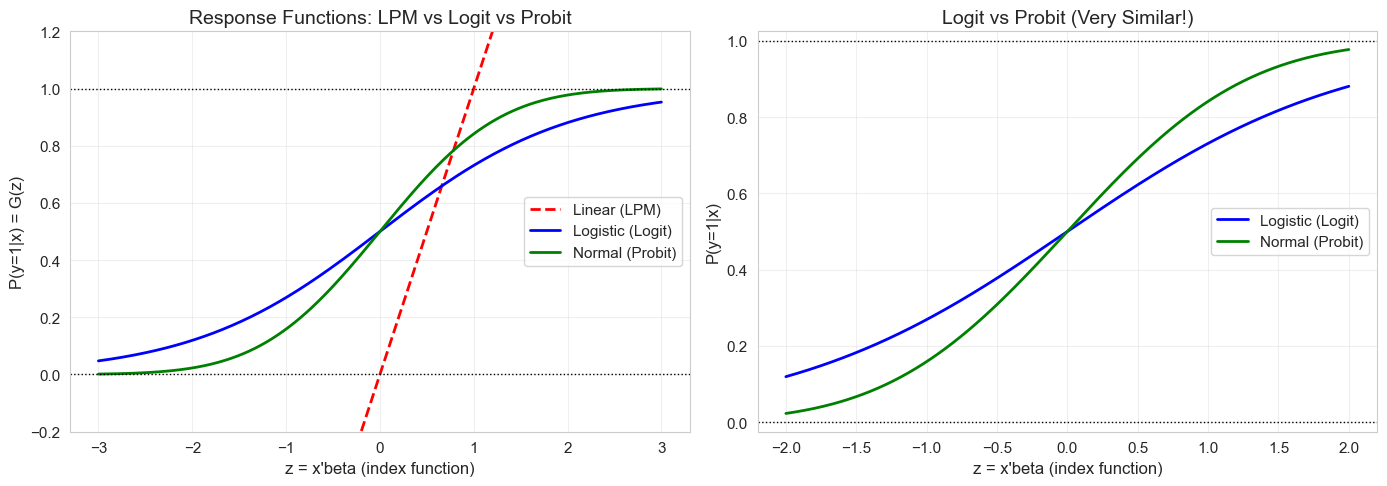


KEY OBSERVATIONS:
YES LPM is linear - can exceed [0, 1]
YES Logit and Probit are S-shaped - always in [0, 1]
YES Logit has slightly heavier tails than Probit
YES Near the middle (z ~= 0), all three are similar


In [10]:
# Visualize the three CDFs
print("\nVISUALIZING THE RESPONSE FUNCTIONS")
print("=" * 70)

# Create range of z values
z = np.linspace(-3, 3, 300)

# Three CDFs
linear = z  # Linear probability (just z)
logistic = 1 / (1 + np.exp(-z))  # Logit
normal = stats.norm.cdf(z)  # Probit

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Panel A: Full range
ax1.plot(z, linear, "r--", linewidth=2, label="Linear (LPM)")
ax1.plot(z, logistic, "b-", linewidth=2, label="Logistic (Logit)")
ax1.plot(z, normal, "g-", linewidth=2, label="Normal (Probit)")
ax1.axhline(y=0, color="black", linestyle=":", linewidth=1)
ax1.axhline(y=1, color="black", linestyle=":", linewidth=1)
ax1.set_xlabel("z = x'beta (index function)")
ax1.set_ylabel("P(y=1|x) = G(z)")
ax1.set_title("Response Functions: LPM vs Logit vs Probit")
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim([-0.2, 1.2])

# Panel B: Zoomed to [0, 1]
z_zoom = np.linspace(-2, 2, 300)
logistic_zoom = 1 / (1 + np.exp(-z_zoom))
normal_zoom = stats.norm.cdf(z_zoom)

ax2.plot(z_zoom, logistic_zoom, "b-", linewidth=2, label="Logistic (Logit)")
ax2.plot(z_zoom, normal_zoom, "g-", linewidth=2, label="Normal (Probit)")
ax2.axhline(y=0, color="black", linestyle=":", linewidth=1)
ax2.axhline(y=1, color="black", linestyle=":", linewidth=1)
ax2.set_xlabel("z = x'beta (index function)")
ax2.set_ylabel("P(y=1|x)")
ax2.set_title("Logit vs Probit (Very Similar!)")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKEY OBSERVATIONS:")
print("YES LPM is linear - can exceed [0, 1]")
print("YES Logit and Probit are S-shaped - always in [0, 1]")
print("YES Logit has slightly heavier tails than Probit")
print("YES Near the middle (z ~= 0), all three are similar")

### Marginal Effects (Partial Effects)

The **coefficients** in logit/probit are NOT marginal effects! We need to calculate:

$$ \frac{\partial P(y=1|\mathbf{x})}{\partial x_j} = g(\mathbf{x}'\boldsymbol{\beta}) \cdot \beta_j $$

where $g(\cdot) = G'(\cdot)$ is the PDF:
- **Logit**: $g(z) = \frac{e^z}{(1 + e^z)^2} = \Lambda(z)[1 - \Lambda(z)]$
- **Probit**: $g(z) = \phi(z) = \frac{1}{\sqrt{2\pi}} e^{-z^2/2}$

**Key insight**: Marginal effects **depend on** $\mathbf{x}$ (evaluated at specific values)!

**Common approaches**:
1. **Marginal Effect at the Mean (MEM)**: Evaluate at $\bar{\mathbf{x}}$
2. **Average Marginal Effect (AME)**: Average over all observations
3. **Marginal Effect at Representative Values (MER)**: Choose interesting cases

In [11]:
# MARGINAL EFFECTS FOR BINARY MODELS
print("\n\n17.1.5 MARGINAL EFFECTS (PARTIAL EFFECTS)")
print("=" * 70)
print("Coefficients in logit/probit are NOT marginal effects!")
print("Must calculate: dP(y=1|x)/dx_j = g(x'beta)*beta_j")

# Average Marginal Effects (AME) for Logit
print("\nLOGIT: Average Marginal Effects (AME)")
print("-" * 70)

# Get fitted values (predicted probabilities)
logit_fitted = logit.predict(mroz)

# Logit PDF: g(z) = Lambda(z)[1 - Lambda(z)]
logit_pdf_values = logit_fitted * (1 - logit_fitted)

# Calculate AME for each coefficient
ame_logit = {}
for var in logit.params.index:
    if var == "Intercept":
        continue
    # For I(exper**2), need special handling
    if var == "I(exper ** 2)":
        ame_logit[var] = (logit_pdf_values * logit.params[var]).mean()
    else:
        ame_logit[var] = (logit_pdf_values * logit.params[var]).mean()

ame_logit_df = pd.DataFrame(
    {"AME": ame_logit, "Logit Coef": logit.params.drop("Intercept")},
)

display(ame_logit_df.round(4))

print("\nINTERPRETATION of Average Marginal Effects:")
print(f"  educ AME: {ame_logit['educ']:.4f}")
print(
    f"    -> 1 more year of education increases participation probability by {100 * ame_logit['educ']:.2f} percentage points (on average)"
)
print(f"  kidslt6 AME: {ame_logit['kidslt6']:.4f}")
print(
    f"    -> 1 more young child decreases participation probability by {abs(100 * ame_logit['kidslt6']):.2f} percentage points (on average)"
)



17.1.5 MARGINAL EFFECTS (PARTIAL EFFECTS)
Coefficients in logit/probit are NOT marginal effects!
Must calculate: dP(y=1|x)/dx_j = g(x'beta)*beta_j

LOGIT: Average Marginal Effects (AME)
----------------------------------------------------------------------


,AME,Logit Coef
nwifeinc,-0.0038,-0.0213
educ,0.0395,0.2212
exper,0.0368,0.2059
I(exper ** 2),-0.0006,-0.0032
age,-0.0157,-0.0880
kidslt6,-0.2578,-1.4434
kidsge6,0.0107,0.0601



INTERPRETATION of Average Marginal Effects:
  educ AME: 0.0395
    -> 1 more year of education increases participation probability by 3.95 percentage points (on average)
  kidslt6 AME: -0.2578
    -> 1 more young child decreases participation probability by 25.78 percentage points (on average)


In [12]:
# Average Marginal Effects (AME) for Probit
print("\nPROBIT: Average Marginal Effects (AME)")
print("-" * 70)

# Get fitted index values
probit_index = probit.predict(mroz, linear=True)

# Probit PDF: g(z) = phi(z) = standard normal PDF
probit_pdf_values = stats.norm.pdf(probit_index)

# Calculate AME for each coefficient
ame_probit = {}
for var in probit.params.index:
    if var == "Intercept":
        continue
    ame_probit[var] = (probit_pdf_values * probit.params[var]).mean()

ame_probit_df = pd.DataFrame(
    {
        "AME": ame_probit,
        "Probit Coef": probit.params.drop("Intercept"),
        "Logit AME": ame_logit,
    },
)

display(ame_probit_df.round(4))

print("\nKEY INSIGHTS:")
print("1. Logit and Probit AMEs are very similar")
print("2. AMEs are comparable to LPM coefficients")
print("3. AMEs have intuitive interpretation (percentage point changes)")
print("4. For small changes, AME ~= LPM coefficient")


PROBIT: Average Marginal Effects (AME)
----------------------------------------------------------------------


/Users/alan/Documents/GitHub/alanlujan91/merino/.venv/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:530: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)


,AME,Probit Coef,Logit AME
nwifeinc,-0.0036,-0.0120,-0.0038
educ,0.0394,0.1309,0.0395
exper,0.0371,0.1233,0.0368
I(exper ** 2),-0.0006,-0.0019,-0.0006
age,-0.0159,-0.0529,-0.0157
kidslt6,-0.2612,-0.8683,-0.2578
kidsge6,0.0108,0.0360,0.0107



KEY INSIGHTS:
1. Logit and Probit AMEs are very similar
2. AMEs are comparable to LPM coefficients
3. AMEs have intuitive interpretation (percentage point changes)
4. For small changes, AME ~= LPM coefficient



MARGINAL EFFECTS DEPEND ON X VALUES!


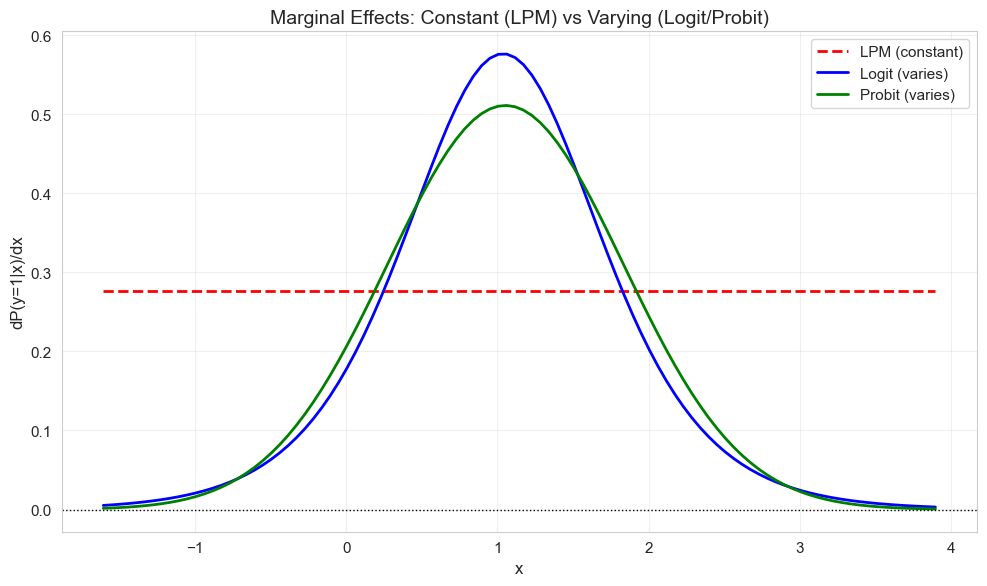


KEY TAKEAWAY:
YES LPM: Marginal effect is constant (same for all x)
YES Logit/Probit: Marginal effect varies with x
YES Largest effects near middle, smaller at extremes
YES Must specify which x values when reporting marginal effects!


In [13]:
# Visualize how marginal effects vary with x
print("\nMARGINAL EFFECTS DEPEND ON X VALUES!")
print("=" * 70)

# Simulate data to show variation
np.random.seed(42)
y_sim = stats.binom.rvs(1, 0.5, size=100)
x_sim = stats.norm.rvs(0, 1, size=100) + 2 * y_sim
sim_data = pd.DataFrame({"y": y_sim, "x": x_sim})

# Estimate three models
reg_lin_sim = smf.ols(formula="y ~ x", data=sim_data).fit()
reg_logit_sim = smf.logit(formula="y ~ x", data=sim_data).fit(disp=0)
reg_probit_sim = smf.probit(formula="y ~ x", data=sim_data).fit(disp=0)

# Calculate marginal effects across range of x
x_range = np.linspace(x_sim.min(), x_sim.max(), 100)

# LPM: constant marginal effect
me_lin = np.repeat(reg_lin_sim.params["x"], 100)

# Logit: g(xbeta) * beta
xb_logit_range = reg_logit_sim.params["Intercept"] + reg_logit_sim.params["x"] * x_range
prob_logit = 1 / (1 + np.exp(-xb_logit_range))
me_logit = prob_logit * (1 - prob_logit) * reg_logit_sim.params["x"]

# Probit: phi(xbeta) * beta
xb_probit_range = (
    reg_probit_sim.params["Intercept"] + reg_probit_sim.params["x"] * x_range
)
me_probit = stats.norm.pdf(xb_probit_range) * reg_probit_sim.params["x"]

# Plot marginal effects
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(x_range, me_lin, "r--", linewidth=2, label="LPM (constant)")
ax.plot(x_range, me_logit, "b-", linewidth=2, label="Logit (varies)")
ax.plot(x_range, me_probit, "g-", linewidth=2, label="Probit (varies)")
ax.axhline(y=0, color="black", linestyle=":", linewidth=1)
ax.set_xlabel("x")
ax.set_ylabel("dP(y=1|x)/dx")
ax.set_title("Marginal Effects: Constant (LPM) vs Varying (Logit/Probit)")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKEY TAKEAWAY:")
print("YES LPM: Marginal effect is constant (same for all x)")
print("YES Logit/Probit: Marginal effect varies with x")
print("YES Largest effects near middle, smaller at extremes")
print("YES Must specify which x values when reporting marginal effects!")

## 17.2 Fractional Response Models

When the dependent variable is a **fraction** or **proportion** (between 0 and 1), but not necessarily binary:

Examples:
- Savings rate (fraction of income saved)
- Portfolio allocation (fraction in stocks)
- Participation rate (fraction of eligible individuals participating)

### Fractional Logit Model

Even though $y$ is not binary, we can use:

$$ E(y | \mathbf{x}) = G(\mathbf{x}'\boldsymbol{\beta}) $$

where $G$ is the logistic CDF. This is a **quasi-MLE** approach:
- Estimator is **consistent** even if $G$ is not the true conditional mean
- Standard errors should be **robust** (heteroskedasticity is inherent)

### Key Advantage

Predictions are **automatically bounded** in (0, 1), unlike OLS which can produce nonsensical predictions.

In [14]:
# FRACTIONAL RESPONSE EXAMPLE (Conceptual)
print("\n17.2 FRACTIONAL RESPONSE MODELS")
print("=" * 70)

print("USE CASE: Dependent variable is a proportion/fraction between 0 and 1")
print("\nEXAMPLES:")
print("  - Savings rate: fraction of income saved")
print("  - Portfolio share: fraction invested in stocks")
print("  - 401(k) participation rate at firm level")

print("\nMODEL:")
print("  E(y|x) = Lambda(x'beta) where 0 < y < 1")
print("  Estimated by quasi-MLE (same as logit)")

print("\nADVANTAGES:")
print("  YES Predictions automatically in (0, 1)")
print("  YES Handles corner solutions (y = 0 or y = 1) naturally")
print("  YES Consistent estimator even if model misspecified")

print("\nESTIMATION:")
print("  1. Use logit estimation with fractional y")
print("  2. Must use robust standard errors")
print("  3. Interpret via average marginal effects")

print("\nNOTE: In Python/statsmodels, use smf.logit() with continuous y in (0,1)")
print("      Some observations can be exactly 0 or 1 (corner solutions)")


17.2 FRACTIONAL RESPONSE MODELS
USE CASE: Dependent variable is a proportion/fraction between 0 and 1

EXAMPLES:
  - Savings rate: fraction of income saved
  - Portfolio share: fraction invested in stocks
  - 401(k) participation rate at firm level

MODEL:
  E(y|x) = Lambda(x'beta) where 0 < y < 1
  Estimated by quasi-MLE (same as logit)

ADVANTAGES:
  YES Predictions automatically in (0, 1)
  YES Handles corner solutions (y = 0 or y = 1) naturally
  YES Consistent estimator even if model misspecified

ESTIMATION:
  1. Use logit estimation with fractional y
  2. Must use robust standard errors
  3. Interpret via average marginal effects

NOTE: In Python/statsmodels, use smf.logit() with continuous y in (0,1)
      Some observations can be exactly 0 or 1 (corner solutions)


## 17.3 An Exponential Mean Model and Poisson Regression

When the dependent variable is a **count** (non-negative integer):

Examples:
- Number of arrests
- Number of patents filed
- Number of doctor visits
- Number of children

### Why Not OLS?

1. $y$ is **discrete** (not continuous)
2. $y \geq 0$ (OLS can predict negative values)
3. **Variance increases with mean** (heteroskedasticity)

### Poisson Regression Model

Assume $y | \mathbf{x}$ follows a **Poisson distribution**:

$$ P(y = h | \mathbf{x}) = \frac{e^{-\mu} \mu^h}{h!}, \quad h = 0, 1, 2, \ldots $$

where the **mean** (and variance) is:

$$ \mu = E(y | \mathbf{x}) = \exp(\mathbf{x}'\boldsymbol{\beta}) $$

**Key feature**: Exponential mean ensures $\mu > 0$ always!

### Interpretation

$$ \log E(y | \mathbf{x}) = \mathbf{x}'\boldsymbol{\beta} $$

So $\beta_j$ is the **semi-elasticity**:

$$ \frac{\partial \log E(y|\mathbf{x})}{\partial x_j} = \beta_j $$

**Interpretation**: A one-unit increase in $x_j$ changes $E(y|\mathbf{x})$ by approximately $100 \cdot \beta_j$ percent.

### Marginal Effects

$$ \frac{\partial E(y|\mathbf{x})}{\partial x_j} = \beta_j \cdot \exp(\mathbf{x}'\boldsymbol{\beta}) = \beta_j \cdot E(y|\mathbf{x}) $$

Marginal effect is **proportional** to the predicted mean!

### Example 17.3: Number of Arrests

In [15]:
# Load arrests data
crime1 = wool.data("crime1")

print("\n17.3 POISSON REGRESSION FOR COUNT DATA")
print("=" * 70)
print("\nEXAMPLE: Number of times arrested in 1986")

print(f"\nTotal observations: {len(crime1)}")
print("\nDEPENDENT VARIABLE:")
print("  narr86 = number of times arrested in 1986")

# Distribution of arrests
arrest_dist = crime1["narr86"].value_counts().sort_index()
print("\nDISTRIBUTION OF ARRESTS:")
display(arrest_dist.head(10))

print(f"\nMean arrests: {crime1['narr86'].mean():.3f}")
print(f"Variance: {crime1['narr86'].var():.3f}")
print(f"Variance/Mean ratio: {crime1['narr86'].var() / crime1['narr86'].mean():.3f}")
print("(Poisson assumes variance = mean; ratio > 1 suggests overdispersion)")

print("\nEXPLANATORY VARIABLES:")
print("  pcnv     = proportion of prior arrests leading to conviction")
print("  avgsen   = average sentence length served (months)")
print("  tottime  = total time served in prison (months)")
print("  ptime86  = months in prison during 1986")
print("  qemp86   = quarters employed in 1986")
print("  inc86    = legal income in 1986 ($100s)")
print("  black    = 1 if black")
print("  hispan   = 1 if Hispanic")
print("  born60   = 1 if born in 1960")


17.3 POISSON REGRESSION FOR COUNT DATA

EXAMPLE: Number of times arrested in 1986

Total observations: 2725

DEPENDENT VARIABLE:
  narr86 = number of times arrested in 1986

DISTRIBUTION OF ARRESTS:


narr86
0     1970
1      559
2      121
3       42
4       12
5       13
6        4
7        1
9        1
10       1
Name: count, dtype: int64


Mean arrests: 0.404
Variance: 0.738
Variance/Mean ratio: 1.825
(Poisson assumes variance = mean; ratio > 1 suggests overdispersion)

EXPLANATORY VARIABLES:
  pcnv     = proportion of prior arrests leading to conviction
  avgsen   = average sentence length served (months)
  tottime  = total time served in prison (months)
  ptime86  = months in prison during 1986
  qemp86   = quarters employed in 1986
  inc86    = legal income in 1986 ($100s)
  black    = 1 if black
  hispan   = 1 if Hispanic
  born60   = 1 if born in 1960


In [16]:
# OLS for comparison
print("\nLINEAR MODEL (OLS) - For Comparison")
print("-" * 70)

ols_count = smf.ols(
    formula="narr86 ~ pcnv + avgsen + tottime + ptime86 + qemp86 + inc86 + black + hispan + born60",
    data=crime1,
).fit()

table_ols = pd.DataFrame(
    {
        "Coefficient": ols_count.params,
        "Std. Error": ols_count.bse,
        "t-statistic": ols_count.tvalues,
        "p-value": ols_count.pvalues,
    },
)

display(table_ols.round(4))

print(f"\nR-squared: {ols_count.rsquared:.4f}")

# Check for negative predictions
ols_pred = ols_count.predict(crime1)
n_negative = (ols_pred < 0).sum()
print(f"\nPredictions < 0: {n_negative} ({100 * n_negative / len(crime1):.1f}%)")
if n_negative > 0:
    print("NO OLS can predict negative arrests!")


LINEAR MODEL (OLS) - For Comparison
----------------------------------------------------------------------


,Coefficient,Std. Error,t-statistic,p-value
Intercept,0.5766,0.0379,15.2150,0.0000
pcnv,-0.1319,0.0404,-3.2642,0.0011
avgsen,-0.0113,0.0122,-0.9257,0.3547
tottime,0.0121,0.0094,1.2790,0.2010
ptime86,-0.0409,0.0088,-4.6378,0.0000
qemp86,-0.0513,0.0145,-3.5420,0.0004
inc86,-0.0015,0.0003,-4.2613,0.0000
black,0.3270,0.0454,7.1987,0.0000
hispan,0.1938,0.0397,4.8799,0.0000
born60,-0.0225,0.0333,-0.6747,0.4999



R-squared: 0.0725

Predictions < 0: 87 (3.2%)
NO OLS can predict negative arrests!


In [17]:
# Poisson regression
print("\n\nPOISSON REGRESSION MODEL")
print("=" * 70)
print("Model: E(narr86|x) = exp(beta_0 + beta_1*pcnv + beta_2*avgsen + ...)")

poisson = smf.poisson(
    formula="narr86 ~ pcnv + avgsen + tottime + ptime86 + qemp86 + inc86 + black + hispan + born60",
    data=crime1,
).fit(disp=0)

table_poisson = pd.DataFrame(
    {
        "Coefficient": poisson.params,
        "Std. Error": poisson.bse,
        "z-statistic": poisson.tvalues,
        "p-value": poisson.pvalues,
    },
)

display(table_poisson.round(4))

print(f"\nLog-Likelihood: {poisson.llf:.4f}")
print(f"AIC: {poisson.aic:.4f}")

print("\nINTERPRETATION (Semi-Elasticities):")
print(f"  pcnv: {poisson.params['pcnv']:.4f}")
print(
    f"    -> 0.1 increase in conviction rate -> {100 * poisson.params['pcnv'] * 0.1:.2f}% change in expected arrests"
)
print(f"  qemp86: {poisson.params['qemp86']:.4f}")
print(
    f"    -> 1 more quarter employed -> {100 * poisson.params['qemp86']:.2f}% change in expected arrests"
)



POISSON REGRESSION MODEL
Model: E(narr86|x) = exp(beta_0 + beta_1*pcnv + beta_2*avgsen + ...)


,Coefficient,Std. Error,z-statistic,p-value
Intercept,-0.5996,0.0673,-8.9158,0.0000
pcnv,-0.4016,0.0850,-4.7260,0.0000
avgsen,-0.0238,0.0199,-1.1918,0.2333
tottime,0.0245,0.0148,1.6603,0.0969
ptime86,-0.0986,0.0207,-4.7625,0.0000
qemp86,-0.0380,0.0290,-1.3099,0.1902
inc86,-0.0081,0.0010,-7.7624,0.0000
black,0.6608,0.0738,8.9503,0.0000
hispan,0.4998,0.0739,6.7609,0.0000
born60,-0.0510,0.0641,-0.7967,0.4256



Log-Likelihood: -2248.7611
AIC: 4517.5222

INTERPRETATION (Semi-Elasticities):
  pcnv: -0.4016
    -> 0.1 increase in conviction rate -> -4.02% change in expected arrests
  qemp86: -0.0380
    -> 1 more quarter employed -> -3.80% change in expected arrests


In [18]:
# Quasi-Poisson (overdispersion correction)
print("\n\nQUASI-POISSON (Overdispersion Correction)")
print("=" * 70)
print("When Var(y|x) > E(y|x), use quasi-Poisson to adjust standard errors")

quasi_poisson = smf.glm(
    formula="narr86 ~ pcnv + avgsen + tottime + ptime86 + qemp86 + inc86 + black + hispan + born60",
    family=sm.families.Poisson(),
    data=crime1,
).fit(scale="X2", disp=0)

table_qpoisson = pd.DataFrame(
    {
        "Coefficient": quasi_poisson.params,
        "Std. Error": quasi_poisson.bse,
        "z-statistic": quasi_poisson.tvalues,
        "p-value": quasi_poisson.pvalues,
    },
)

display(table_qpoisson.round(4))

print(f"\nDispersion parameter: {quasi_poisson.scale:.4f}")
print("(> 1 confirms overdispersion)")



QUASI-POISSON (Overdispersion Correction)
When Var(y|x) > E(y|x), use quasi-Poisson to adjust standard errors


,Coefficient,Std. Error,z-statistic,p-value
Intercept,-0.5996,0.0828,-7.2393,0.0000
pcnv,-0.4016,0.1046,-3.8373,0.0001
avgsen,-0.0238,0.0246,-0.9677,0.3332
tottime,0.0245,0.0182,1.3481,0.1776
ptime86,-0.0986,0.0255,-3.8670,0.0001
qemp86,-0.0380,0.0357,-1.0636,0.2875
inc86,-0.0081,0.0013,-6.3028,0.0000
black,0.6608,0.0909,7.2673,0.0000
hispan,0.4998,0.0910,5.4896,0.0000
born60,-0.0510,0.0789,-0.6469,0.5177



Dispersion parameter: 1.5168
(> 1 confirms overdispersion)


In [19]:
# Compare all three models
print("\n\nCOMPARISON: OLS vs POISSON vs QUASI-POISSON")
print("=" * 70)

comparison_count = pd.DataFrame(
    {
        "OLS": ols_count.params,
        "OLS SE": ols_count.bse,
        "Poisson": poisson.params,
        "Poisson SE": poisson.bse,
        "Quasi-Poisson": quasi_poisson.params,
        "Quasi-Poisson SE": quasi_poisson.bse,
    },
)

display(comparison_count.round(4))

print("\nKEY INSIGHTS:")
print("1. Poisson coefficients are semi-elasticities (not levels like OLS)")
print("2. Quasi-Poisson has larger SEs (accounts for overdispersion)")
print("3. Pattern of significance similar across models")
print("4. Poisson ensures non-negative predictions")



COMPARISON: OLS vs POISSON vs QUASI-POISSON


,OLS,OLS SE,Poisson,Poisson SE,Quasi-Poisson,Quasi-Poisson SE
Intercept,0.5766,0.0379,-0.5996,0.0673,-0.5996,0.0828
pcnv,-0.1319,0.0404,-0.4016,0.0850,-0.4016,0.1046
avgsen,-0.0113,0.0122,-0.0238,0.0199,-0.0238,0.0246
tottime,0.0121,0.0094,0.0245,0.0148,0.0245,0.0182
ptime86,-0.0409,0.0088,-0.0986,0.0207,-0.0986,0.0255
qemp86,-0.0513,0.0145,-0.0380,0.0290,-0.0380,0.0357
inc86,-0.0015,0.0003,-0.0081,0.0010,-0.0081,0.0013
black,0.3270,0.0454,0.6608,0.0738,0.6608,0.0909
hispan,0.1938,0.0397,0.4998,0.0739,0.4998,0.0910
born60,-0.0225,0.0333,-0.0510,0.0641,-0.0510,0.0789



KEY INSIGHTS:
1. Poisson coefficients are semi-elasticities (not levels like OLS)
2. Quasi-Poisson has larger SEs (accounts for overdispersion)
3. Pattern of significance similar across models
4. Poisson ensures non-negative predictions


## 17.4 The Tobit Model for Corner Solution Responses

A **corner solution** occurs when the dependent variable:
- Takes value **zero for a substantial fraction** of observations
- Takes **positive continuous values** for the rest

Examples:
- **Hours worked**: Many people don't work (hours = 0), others work positive hours
- **Charitable contributions**: Many give nothing, others give positive amounts
- **Savings**: Some save nothing, others save positive amounts

### Why Not OLS?

OLS treats zeros as just another value, but zeros are **qualitatively different** (corner solutions from optimization, not "small positive values").

### Tobit Model (Type I Tobit / Censored Regression)

**Latent variable** model:

$$ y^* = \mathbf{x}'\boldsymbol{\beta} + u, \quad u | \mathbf{x} \sim N(0, \sigma^2) $$

**Observation rule**:

$$ y = \max(0, y^*) = \begin{cases} y^* & \text{if } y^* > 0 \\ 0 & \text{if } y^* \leq 0 \end{cases} $$

Think of $y^*$ as **desired hours** (can be negative = don't want to work).
We observe $y$ = **actual hours** (cannot be negative).

### Likelihood Function

Two parts:

1. **For $y = 0$**: $P(y = 0 | \mathbf{x}) = P(y^* \leq 0 | \mathbf{x}) = \Phi\left(-\frac{\mathbf{x}'\boldsymbol{\beta}}{\sigma}\right)$

2. **For $y > 0$**: $f(y | \mathbf{x}) = \frac{1}{\sigma} \phi\left(\frac{y - \mathbf{x}'\boldsymbol{\beta}}{\sigma}\right)$

Log-likelihood:

$$ \ell(\boldsymbol{\beta}, \sigma) = \sum_{y_i=0} \log \Phi\left(-\frac{\mathbf{x}_i'\boldsymbol{\beta}}{\sigma}\right) + \sum_{y_i>0} \left[\log \phi\left(\frac{y_i - \mathbf{x}_i'\boldsymbol{\beta}}{\sigma}\right) - \log \sigma\right] $$

### Interpretation

**Marginal effects** are complex:

1. **Effect on latent variable**: $\frac{\partial E(y^* | \mathbf{x})}{\partial x_j} = \beta_j$

2. **Effect on observed variable**: 
$$ \frac{\partial E(y | \mathbf{x})}{\partial x_j} = \Phi\left(\frac{\mathbf{x}'\boldsymbol{\beta}}{\sigma}\right) \cdot \beta_j $$

3. **Effect on positive outcomes** (given $y > 0$):
$$ \frac{\partial E(y | \mathbf{x}, y > 0)}{\partial x_j} = \left[1 - \lambda\left(\frac{\mathbf{x}'\boldsymbol{\beta}}{\sigma}\right) \cdot \frac{\mathbf{x}'\boldsymbol{\beta}}{\sigma}\right] \beta_j $$

where $\lambda(z) = \phi(z) / \Phi(z)$ is the **inverse Mills ratio**.

### Example 17.2: Married Women's Hours Worked


17.4 TOBIT MODEL FOR CORNER SOLUTION RESPONSES

EXAMPLE: Annual hours worked by married women

Total observations: 753
Women with hours = 0: 325 (43.2%)
Women with hours > 0: 428 (56.8%)

DEPENDENT VARIABLE:
  hours = annual hours worked
  Corner solution: hours >= 0, with many zeros

EXPLANATORY VARIABLES:
  nwifeinc = husband's income
  educ     = education
  exper    = experience
  age      = age
  kidslt6  = number of young children
  kidsge6  = number of older children


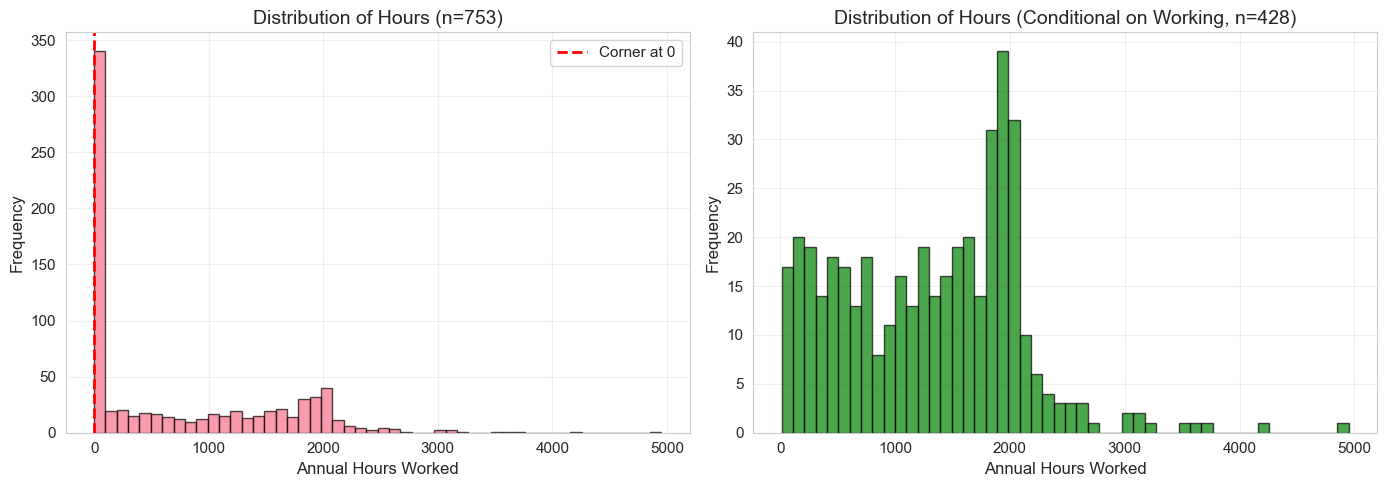


Summary statistics (all women):


count     753.00
mean      740.58
std       871.31
min         0.00
25%         0.00
50%       288.00
75%      1516.00
max      4950.00
Name: hours, dtype: float64


Summary statistics (working women only):


count     428.00
mean     1302.93
std       776.27
min        12.00
25%       609.50
50%      1365.50
75%      1910.50
max      4950.00
Name: hours, dtype: float64

In [20]:
# Load data (all married women, including non-workers)
mroz = wool.data("mroz")

print("\n17.4 TOBIT MODEL FOR CORNER SOLUTION RESPONSES")
print("=" * 70)
print("\nEXAMPLE: Annual hours worked by married women")

print(f"\nTotal observations: {len(mroz)}")
print(
    f"Women with hours = 0: {(mroz['hours'] == 0).sum()} ({100 * (mroz['hours'] == 0).mean():.1f}%)"
)
print(
    f"Women with hours > 0: {(mroz['hours'] > 0).sum()} ({100 * (mroz['hours'] > 0).mean():.1f}%)"
)

print("\nDEPENDENT VARIABLE:")
print("  hours = annual hours worked")
print("  Corner solution: hours >= 0, with many zeros")

print("\nEXPLANATORY VARIABLES:")
print("  nwifeinc = husband's income")
print("  educ     = education")
print("  exper    = experience")
print("  age      = age")
print("  kidslt6  = number of young children")
print("  kidsge6  = number of older children")

# Distribution of hours
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of all hours (including zeros)
ax1.hist(mroz["hours"], bins=50, edgecolor="black", alpha=0.7)
ax1.axvline(x=0, color="red", linestyle="--", linewidth=2, label="Corner at 0")
ax1.set_xlabel("Annual Hours Worked")
ax1.set_ylabel("Frequency")
ax1.set_title(f"Distribution of Hours (n={len(mroz)})")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Histogram of positive hours only
hours_positive = mroz[mroz["hours"] > 0]["hours"]
ax2.hist(hours_positive, bins=50, edgecolor="black", alpha=0.7, color="green")
ax2.set_xlabel("Annual Hours Worked")
ax2.set_ylabel("Frequency")
ax2.set_title(
    f"Distribution of Hours (Conditional on Working, n={len(hours_positive)})"
)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nSummary statistics (all women):")
display(mroz["hours"].describe().round(2))

print("\nSummary statistics (working women only):")
display(hours_positive.describe().round(2))

In [21]:
# OLS for comparison (wrong!)
print("\nOLS REGRESSION (WRONG - Ignores Corner Solution)")
print("=" * 70)

ols_hours = smf.ols(
    formula="hours ~ nwifeinc + educ + exper + I(exper**2) + age + kidslt6 + kidsge6",
    data=mroz,
).fit()

table_ols_hours = pd.DataFrame(
    {
        "Coefficient": ols_hours.params,
        "Std. Error": ols_hours.bse,
        "t-statistic": ols_hours.tvalues,
        "p-value": ols_hours.pvalues,
    },
)

display(table_ols_hours.round(4))

print(f"\nR-squared: {ols_hours.rsquared:.4f}")
print("\nPROBLEM: OLS treats 0 hours like any other value")
print("         Doesn't account for corner solution nature of the data")


OLS REGRESSION (WRONG - Ignores Corner Solution)


,Coefficient,Std. Error,t-statistic,p-value
Intercept,1330.4824,270.7846,4.9134,0.0000
nwifeinc,-3.4466,2.5440,-1.3548,0.1759
educ,28.7611,12.9546,2.2201,0.0267
exper,65.6725,9.9630,6.5917,0.0000
I(exper ** 2),-0.7005,0.3246,-2.1584,0.0312
age,-30.5116,4.3639,-6.9919,0.0000
kidslt6,-442.0899,58.8466,-7.5126,0.0000
kidsge6,-32.7792,23.1762,-1.4143,0.1577



R-squared: 0.2656

PROBLEM: OLS treats 0 hours like any other value
         Doesn't account for corner solution nature of the data


In [22]:
# Tobit model - custom MLE class
print("\n\nTOBIT MODEL")
print("=" * 70)
print("Model: y* = x'beta + u, u ~ N(0, sigma^2)")
print("       y = max(0, y*)")

# Prepare data using patsy
y, X = pt.dmatrices(
    "hours ~ nwifeinc + educ + exper + I(exper**2) + age + kidslt6 + kidsge6",
    data=mroz,
    return_type="dataframe",
)

# Get starting values from OLS
reg_ols_start = smf.ols(
    formula="hours ~ nwifeinc + educ + exper + I(exper**2) + age + kidslt6 + kidsge6",
    data=mroz,
).fit()

sigma_start = np.log(sum(reg_ols_start.resid**2) / len(reg_ols_start.resid))
params_start = np.concatenate(
    (np.array(reg_ols_start.params), [sigma_start]), axis=None
)


# Define Tobit model class
class Tobit(GenericLikelihoodModel):
    """Tobit model for corner solution responses."""

    def nloglikeobs(self, params):
        """Negative log-likelihood per observation for Tobit model.

        For details see Wooldridge (2019), formula 17.22:
        - For y = 0: contribution is log[Phi(-xbeta/sigma)]
        - For y > 0: contribution is log[phi((y-xbeta)/sigma)] - log(sigma)
        """
        X = self.exog
        y = self.endog
        p = X.shape[1]

        # Extract parameters
        beta = params[0:p]
        sigma = np.exp(params[p])  # Ensure sigma > 0

        # Predicted values
        y_hat = np.dot(X, beta)

        # Identify censored and uncensored observations
        y_eq = y == 0  # Censored at zero
        y_g = y > 0  # Uncensored

        # Initialize log-likelihood array
        ll = np.empty(len(y))

        # Censored observations: log[Phi(-xbeta/sigma)]
        ll[y_eq] = np.log(stats.norm.cdf(-y_hat[y_eq] / sigma))

        # Uncensored observations: log[phi((y-xbeta)/sigma)] - log(sigma)
        ll[y_g] = np.log(stats.norm.pdf((y - y_hat)[y_g] / sigma)) - np.log(sigma)

        # Return negative log-likelihood
        return -ll


# Estimate Tobit model
print("\nEstimating Tobit model via Maximum Likelihood...")
tobit = Tobit(endog=y, exog=X)
tobit_results = tobit.fit(start_params=params_start, maxiter=10000, disp=0)

print("\nTOBIT MODEL RESULTS:")
print(tobit_results.summary())

# Extract sigma
sigma_hat = np.exp(tobit_results.params[-1])
print(f"\nEstimated sigma: {sigma_hat:.4f}")



TOBIT MODEL
Model: y* = x'beta + u, u ~ N(0, sigma^2)
       y = max(0, y*)



Estimating Tobit model via Maximum Likelihood...



TOBIT MODEL RESULTS:
                                Tobit Results                                 
Dep. Variable:                  hours   Log-Likelihood:                -3819.1
Model:                          Tobit   AIC:                             7656.
Method:            Maximum Likelihood   BIC:                             7698.
Date:                Mon, 20 Oct 2025                                         
Time:                        20:08:39                                         
No. Observations:                 753                                         
Df Residuals:                     745                                         
Df Model:                           7                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       965.3051    446.435      2.162      0.031      90.309    1840.301
nwifeinc         -8.8

/Users/alan/Documents/GitHub/alanlujan91/merino/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:2748: UserWarning: df_model + k_constant + k_extra differs from k_params
  warnings.warn("df_model + k_constant + k_extra "
/Users/alan/Documents/GitHub/alanlujan91/merino/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:2752: UserWarning: df_resid differs from nobs - k_params
  warnings.warn("df_resid differs from nobs - k_params")


In [23]:
# Compare OLS and Tobit
print("\nCOMPARISON: OLS vs TOBIT")
print("=" * 70)

# Get Tobit parameters (exclude sigma)
tobit_coef = tobit_results.params[:-1]
tobit_se = tobit_results.bse[:-1]

comparison_tobit = pd.DataFrame(
    {
        "OLS": ols_hours.params,
        "OLS SE": ols_hours.bse,
        "Tobit": tobit_coef,
        "Tobit SE": tobit_se,
    },
)

display(comparison_tobit.round(4))

print("\nKEY INSIGHTS:")
print("1. Tobit coefficients are typically LARGER than OLS")
print("2. Tobit accounts for corner solution (selection into working)")
print("3. OLS suffers from 'attenuation bias' (biased toward zero)")
print("4. Tobit interpretation: effect on LATENT variable y*")


COMPARISON: OLS vs TOBIT


,OLS,OLS SE,Tobit,Tobit SE
Intercept,1330.4824,270.7846,965.3051,446.4349
nwifeinc,-3.4466,2.5440,-8.8142,4.4591
educ,28.7611,12.9546,80.6456,21.5832
exper,65.6725,9.9630,131.5643,17.2794
I(exper ** 2),-0.7005,0.3246,-1.8642,0.5377
age,-30.5116,4.3639,-54.4050,7.4185
kidslt6,-442.0899,58.8466,-894.0218,111.8780
kidsge6,-32.7792,23.1762,-16.2180,38.6411



KEY INSIGHTS:
1. Tobit coefficients are typically LARGER than OLS
2. Tobit accounts for corner solution (selection into working)
3. OLS suffers from 'attenuation bias' (biased toward zero)
4. Tobit interpretation: effect on LATENT variable y*


In [24]:
# Calculate marginal effects
print("\n\nTOBIT MARGINAL EFFECTS")
print("=" * 70)

# Marginal effect on E(y|x) = Phi(xbeta/sigma) * beta
# Calculate at sample means

X_mean = X.mean(axis=0).values
xb_mean = np.dot(X_mean, tobit_coef)
prob_positive = stats.norm.cdf(xb_mean / sigma_hat)

print("At sample means:")
print(f"  x'beta = {xb_mean:.4f}")
print(f"  Phi(x'beta/sigma) = {prob_positive:.4f}")

# Marginal effects on E(y|x)
me_tobit = prob_positive * tobit_coef

me_tobit_df = pd.DataFrame(
    {
        "Tobit Coef (dy*/dx)": tobit_coef,
        "ME on E(y|x)": me_tobit,
        "OLS Coef": ols_hours.params,
    },
)

display(me_tobit_df.round(4))

print("\nINTERPRETATION:")
educ_idx = list(X.columns).index("educ")
kidslt6_idx = list(X.columns).index("kidslt6")

print(f"  educ (Tobit coef): {tobit_coef[educ_idx]:.2f}")
print(
    f"    -> 1 more year of education increases y* by {tobit_coef[educ_idx]:.2f} hours"
)
print(f"  educ (ME on E(y|x)): {me_tobit[educ_idx]:.2f}")
print(
    f"    -> 1 more year of education increases E(hours|x) by {me_tobit[educ_idx]:.2f} hours"
)
print(
    "    -> Accounts for both: (1) more likely to work, (2) work more hours if working"
)

print(f"\n  kidslt6 (Tobit coef): {tobit_coef[kidslt6_idx]:.2f}")
print(
    f"    -> 1 more young child decreases y* by {abs(tobit_coef[kidslt6_idx]):.2f} hours"
)
print(f"  kidslt6 (ME on E(y|x)): {me_tobit[kidslt6_idx]:.2f}")
print(
    f"    -> 1 more young child decreases E(hours|x) by {abs(me_tobit[kidslt6_idx]):.2f} hours"
)



TOBIT MARGINAL EFFECTS
At sample means:
  x'beta = 296.7653
  Phi(x'beta/sigma) = 0.6043


,Tobit Coef (dy*/dx),ME on E(y|x),OLS Coef
Intercept,965.3051,583.3333,1330.4824
nwifeinc,-8.8142,-5.3264,-3.4466
educ,80.6456,48.7341,28.7611
exper,131.5643,79.5042,65.6725
I(exper ** 2),-1.8642,-1.1265,-0.7005
age,-54.4050,-32.8769,-30.5116
kidslt6,-894.0218,-540.2569,-442.0899
kidsge6,-16.2180,-9.8005,-32.7792



INTERPRETATION:
  educ (Tobit coef): 80.65
    -> 1 more year of education increases y* by 80.65 hours
  educ (ME on E(y|x)): 48.73
    -> 1 more year of education increases E(hours|x) by 48.73 hours
    -> Accounts for both: (1) more likely to work, (2) work more hours if working

  kidslt6 (Tobit coef): -894.02
    -> 1 more young child decreases y* by 894.02 hours
  kidslt6 (ME on E(y|x)): -540.26
    -> 1 more young child decreases E(hours|x) by 540.26 hours


## 17.5 Censored and Truncated Regression Models

**Censoring** and **truncation** both involve incomplete observation, but they differ fundamentally:

### Censored Regression

**Censoring**: We observe **all** individuals, but the dependent variable is **censored** (cut off) at some value.

Example: **Duration until re-arrest** (recidivism study)
- Some ex-convicts are re-arrested during study period -> observe exact duration
- Others are NOT re-arrested by study end -> observe only that duration > T (right-censored)

**Censored regression model** (similar to Tobit):

$$ y^* = \mathbf{x}'\boldsymbol{\beta} + u, \quad u \sim N(0, \sigma^2) $$

$$ y = \begin{cases} y^* & \text{if } y^* < c \text{ (uncensored)} \\ c & \text{if } y^* \geq c \text{ (censored at } c) \end{cases} $$

**Key**: We know which observations are censored!

### Truncated Regression

**Truncation**: We **only observe** individuals for whom $y$ satisfies some condition.

Example: **Wage study of working women**
- Only observe wages for women who work (hours > 0)
- Don't observe non-workers at all (missing from sample)

**Truncated regression** accounts for non-random sampling:

$$ f(y | \mathbf{x}, y > 0) = \frac{\phi\left(\frac{y - \mathbf{x}'\boldsymbol{\beta}}{\sigma}\right) / \sigma}{\Phi\left(\frac{\mathbf{x}'\boldsymbol{\beta}}{\sigma}\right)} $$

**Key**: Sample is **selected** based on $y$!

### Key Difference

|  | **Censored** | **Truncated** |
|---|---|---|
| **Sample** | Observe all individuals | Only some individuals |
| **Information** | Know who is censored | Don't know truncated observations |
| **Example** | Prison duration (some ongoing) | Wages (only workers) |
| **Correction** | Model censoring explicitly | Condition on truncation |

### Example 17.4: Censored Regression (Recidivism)

In [25]:
# Load recidivism data
recid = wool.data("recid")

print("\n17.5 CENSORED AND TRUNCATED REGRESSION")
print("=" * 70)
print("\nEXAMPLE 17.4: Duration Until Re-Arrest (Censored Regression)")

print(f"\nTotal observations: {len(recid)}")
print("\nDEPENDENT VARIABLE:")
print("  durat = months until re-arrest (or end of study)")
print("  ldurat = log(durat)")

# Check censoring
print("\nCENSORING:")
print(
    f"  Uncensored (re-arrested): {(recid['cens'] == 0).sum()} ({100 * (recid['cens'] == 0).mean():.1f}%)"
)
print(
    f"  Censored (not re-arrested): {(recid['cens'] == 1).sum()} ({100 * (recid['cens'] == 1).mean():.1f}%)"
)

print("\nEXPLANATORY VARIABLES:")
print("  workprg = 1 if participated in work program")
print("  priors  = number of prior convictions")
print("  tserved = months served in prison")
print("  felon   = 1 if felony conviction")
print("  alcohol = 1 if alcohol problems")
print("  drugs   = 1 if drug history")
print("  black   = 1 if black")
print("  married = 1 if married")
print("  educ    = years of education")
print("  age     = age at release")

# Summary statistics
key_vars = ["ldurat", "workprg", "priors", "tserved", "felon", "age", "educ"]
display(recid[key_vars].describe().round(2))


17.5 CENSORED AND TRUNCATED REGRESSION

EXAMPLE 17.4: Duration Until Re-Arrest (Censored Regression)

Total observations: 1445

DEPENDENT VARIABLE:
  durat = months until re-arrest (or end of study)
  ldurat = log(durat)

CENSORING:
  Uncensored (re-arrested): 552 (38.2%)
  Censored (not re-arrested): 893 (61.8%)

EXPLANATORY VARIABLES:
  workprg = 1 if participated in work program
  priors  = number of prior convictions
  tserved = months served in prison
  felon   = 1 if felony conviction
  alcohol = 1 if alcohol problems
  drugs   = 1 if drug history
  black   = 1 if black
  married = 1 if married
  educ    = years of education
  age     = age at release


,ldurat,workprg,priors,tserved,felon,age,educ
count,1445.00,1445.00,1445.00,1445.00,1445.00,1445.00,1445.00
mean,3.75,0.47,1.43,19.18,0.31,345.44,9.70
std,0.93,0.50,2.85,20.96,0.46,121.05,2.44
min,0.00,0.00,0.00,0.00,0.00,198.00,1.00
25%,3.30,0.00,0.00,6.00,0.00,258.00,8.00
50%,4.26,0.00,0.00,12.00,0.00,307.00,10.00
75%,4.33,1.00,2.00,25.00,1.00,395.00,11.00
max,4.39,1.00,28.00,219.00,1.00,933.00,19.00


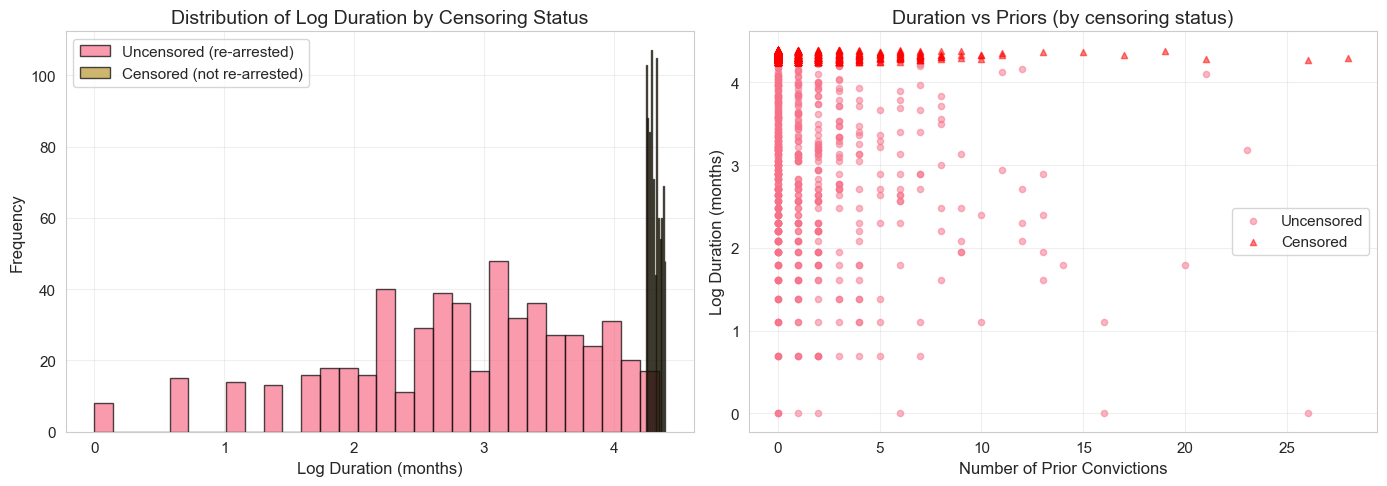

In [26]:
# Visualize censoring
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram by censoring status
uncensored = recid[recid["cens"] == 0]["ldurat"]
censored = recid[recid["cens"] == 1]["ldurat"]

axes[0].hist(
    uncensored, bins=30, alpha=0.7, label="Uncensored (re-arrested)", edgecolor="black"
)
axes[0].hist(
    censored, bins=30, alpha=0.7, label="Censored (not re-arrested)", edgecolor="black"
)
axes[0].set_xlabel("Log Duration (months)")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of Log Duration by Censoring Status")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Scatter: duration vs priors
axes[1].scatter(
    recid[recid["cens"] == 0]["priors"],
    recid[recid["cens"] == 0]["ldurat"],
    alpha=0.5,
    s=20,
    label="Uncensored",
)
axes[1].scatter(
    recid[recid["cens"] == 1]["priors"],
    recid[recid["cens"] == 1]["ldurat"],
    alpha=0.5,
    s=20,
    color="red",
    marker="^",
    label="Censored",
)
axes[1].set_xlabel("Number of Prior Convictions")
axes[1].set_ylabel("Log Duration (months)")
axes[1].set_title("Duration vs Priors (by censoring status)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [27]:
# Censored regression model
print("\nCENSORED REGRESSION MODEL")
print("=" * 70)
print("Model: log(duration)* = x'beta + u, u ~ N(0, sigma^2)")
print("       Observe log(duration) if re-arrested")
print("       Censored if not re-arrested (duration > study period)")

# Prepare data
censored = recid["cens"] != 0
y, X = pt.dmatrices(
    "ldurat ~ workprg + priors + tserved + felon + alcohol + drugs + black + married + educ + age",
    data=recid,
    return_type="dataframe",
)

# Get starting values from OLS
reg_ols_cens = smf.ols(
    formula="ldurat ~ workprg + priors + tserved + felon + alcohol + drugs + black + married + educ + age",
    data=recid,
).fit()

sigma_start = np.log(sum(reg_ols_cens.resid**2) / len(reg_ols_cens.resid))
params_start = np.concatenate((np.array(reg_ols_cens.params), [sigma_start]), axis=None)


# Define censored regression model class
class CensoredRegression(GenericLikelihoodModel):
    """Censored regression model for right-censored data."""

    def __init__(self, endog, cens, exog):
        self.cens = cens
        super().__init__(endog, exog, missing="none")

    def nloglikeobs(self, params):
        """Negative log-likelihood per observation.

        For uncensored: standard normal density
        For censored: probability of being above censoring point
        """
        X = self.exog
        y = self.endog
        cens = self.cens
        p = X.shape[1]

        beta = params[0:p]
        sigma = np.exp(params[p])
        y_hat = np.dot(X, beta)

        ll = np.empty(len(y))

        # Uncensored: log[phi((y-xbeta)/sigma)] - log(sigma)
        ll[~cens] = np.log(stats.norm.pdf((y - y_hat)[~cens] / sigma)) - np.log(sigma)

        # Censored: log[Phi(-(y-xbeta)/sigma)]
        ll[cens] = np.log(stats.norm.cdf(-(y - y_hat)[cens] / sigma))

        return -ll


# Estimate censored regression
print("\nEstimating Censored Regression model...")
censreg = CensoredRegression(endog=y, exog=X, cens=censored)
censreg_results = censreg.fit(
    start_params=params_start, maxiter=10000, method="BFGS", disp=0
)

print("\nCENSORED REGRESSION RESULTS:")
print(censreg_results.summary())

# Extract sigma
sigma_censreg = np.exp(censreg_results.params[-1])
print(f"\nEstimated sigma: {sigma_censreg:.4f}")


CENSORED REGRESSION MODEL
Model: log(duration)* = x'beta + u, u ~ N(0, sigma^2)
       Observe log(duration) if re-arrested
       Censored if not re-arrested (duration > study period)

Estimating Censored Regression model...


/var/folders/rg/vmn_nq41613gkxt0_9spwzx80000gp/T/ipykernel_77822/2809505758.py:52: RuntimeWarning: divide by zero encountered in log
  ll[~cens] = np.log(stats.norm.pdf((y - y_hat)[~cens] / sigma)) - np.log(sigma)
/Users/alan/Documents/GitHub/alanlujan91/merino/.venv/lib/python3.11/site-packages/statsmodels/tools/numdiff.py:157: RuntimeWarning: invalid value encountered in scalar subtract
  grad[k, :] = (f(*((x+ei,)+args), **kwargs) -
/var/folders/rg/vmn_nq41613gkxt0_9spwzx80000gp/T/ipykernel_77822/2809505758.py:52: RuntimeWarning: divide by zero encountered in log
  ll[~cens] = np.log(stats.norm.pdf((y - y_hat)[~cens] / sigma)) - np.log(sigma)



CENSORED REGRESSION RESULTS:
                          CensoredRegression Results                          
Dep. Variable:                 ldurat   Log-Likelihood:                -1597.1
Model:             CensoredRegression   AIC:                             3218.
Method:            Maximum Likelihood   BIC:                             3281.
Date:                Mon, 20 Oct 2025                                         
Time:                        20:08:39                                         
No. Observations:                1445                                         
Df Residuals:                    1434                                         
Df Model:                          10                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0994      0.348     11.796      0.000       3.418       4.781
workprg       -0.0626 

/Users/alan/Documents/GitHub/alanlujan91/merino/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:2748: UserWarning: df_model + k_constant + k_extra differs from k_params
  warnings.warn("df_model + k_constant + k_extra "
/Users/alan/Documents/GitHub/alanlujan91/merino/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:2752: UserWarning: df_resid differs from nobs - k_params
  warnings.warn("df_resid differs from nobs - k_params")


In [28]:
# Compare OLS and Censored Regression
print("\nCOMPARISON: OLS vs CENSORED REGRESSION")
print("=" * 70)

# Get censored regression parameters (exclude sigma)
censreg_coef = censreg_results.params[:-1]
censreg_se = censreg_results.bse[:-1]

comparison_censreg = pd.DataFrame(
    {
        "OLS": reg_ols_cens.params,
        "OLS SE": reg_ols_cens.bse,
        "Censored Reg": censreg_coef,
        "Censored Reg SE": censreg_se,
    },
)

display(comparison_censreg.round(4))

print("\nKEY INSIGHTS:")
print("1. Censored regression accounts for right-censoring")
print("2. OLS treats censored observations as if uncensored (biased)")
print("3. workprg effect: Work program increases time to re-arrest")
print("4. priors effect: More prior convictions -> shorter time to re-arrest")

print("\nINTERPRETATION:")
workprg_idx = list(X.columns).index("workprg")
priors_idx = list(X.columns).index("priors")

print(f"  workprg: {censreg_coef[workprg_idx]:.4f}")
print(f"    -> Work program increases log(duration) by {censreg_coef[workprg_idx]:.4f}")
print(
    f"    -> Increases duration by {100 * (np.exp(censreg_coef[workprg_idx]) - 1):.1f}%"
)
print(f"  priors: {censreg_coef[priors_idx]:.4f}")
print(
    f"    -> 1 more prior conviction decreases log(duration) by {abs(censreg_coef[priors_idx]):.4f}"
)
print(
    f"    -> Decreases duration by {100 * (1 - np.exp(censreg_coef[priors_idx])):.1f}%"
)


COMPARISON: OLS vs CENSORED REGRESSION


,OLS,OLS SE,Censored Reg,Censored Reg SE
Intercept,3.5692,0.1380,4.0994,0.3475
workprg,0.0088,0.0489,-0.0626,0.1200
priors,-0.0591,0.0092,-0.1373,0.0215
tserved,-0.0094,0.0013,-0.0193,0.0030
felon,0.1785,0.0584,0.4440,0.1451
alcohol,-0.2628,0.0598,-0.6349,0.1442
drugs,-0.0907,0.0549,-0.2982,0.1327
black,-0.1791,0.0474,-0.5427,0.1174
married,0.1344,0.0554,0.3407,0.1398
educ,0.0054,0.0099,0.0229,0.0254



KEY INSIGHTS:
1. Censored regression accounts for right-censoring
2. OLS treats censored observations as if uncensored (biased)
3. workprg effect: Work program increases time to re-arrest
4. priors effect: More prior convictions -> shorter time to re-arrest

INTERPRETATION:
  workprg: -0.0626
    -> Work program increases log(duration) by -0.0626
    -> Increases duration by -6.1%
  priors: -0.1373
    -> 1 more prior conviction decreases log(duration) by 0.1373
    -> Decreases duration by 12.8%


## 17.6 Sample Selection Corrections

**Sample selection bias** occurs when the sample is **not randomly selected** from the population, leading to biased estimates if not corrected.

### Classic Example: Wage Equation for Women

We want to estimate the wage equation:

$$ \log(\text{wage}) = \beta_0 + \beta_1 \text{educ} + \beta_2 \text{exper} + \beta_3 \text{exper}^2 + u $$

**Problem**: We only observe wages for **women who work**! Selection into working is not random:

$$ \text{inlf} = 1[\gamma_0 + \gamma_1 \text{educ} + \cdots + \gamma_k \mathbf{z} + v > 0] $$

If $\text{Cov}(u, v) \neq 0$, then OLS on the working sample is **biased**!

**Intuition**: Women with high unobserved wage offers ($u > 0$) are more likely to work. In the working sample, $E(u | \text{work}) \neq 0$ -> OLS is biased.

### Heckman's Two-Step Procedure

**Step 1**: Estimate **probit selection equation** using all observations:

$$ \text{Pr}(\text{inlf} = 1 | \mathbf{z}) = \Phi(\mathbf{z}'\boldsymbol{\gamma}) $$

Compute the **inverse Mills ratio**:

$$ \hat{\lambda}_i = \frac{\phi(\mathbf{z}_i'\hat{\boldsymbol{\gamma}})}{\Phi(\mathbf{z}_i'\hat{\boldsymbol{\gamma}})} $$

**Step 2**: Estimate **outcome equation** including $\hat{\lambda}_i$ as a regressor (using only working women):

$$ \log(\text{wage}_i) = \beta_0 + \beta_1 \text{educ}_i + \beta_2 \text{exper}_i + \beta_3 \text{exper}_i^2 + \theta \hat{\lambda}_i + \text{error} $$

**Key**:
- $\hat{\lambda}_i$ **controls for selection bias**
- If $\theta$ is significant -> evidence of selection bias
- If $\theta \approx 0$ -> OLS on working sample is approximately unbiased

### Identification

For identification, need at least one variable in $\mathbf{z}$ (selection equation) that's **excluded** from $\mathbf{x}$ (outcome equation).

**Exclusion restriction**: This variable affects **selection** but not the **outcome directly** (only through selection).

Common choices:
- **Non-labor income** (affects work decision, not wage offer)
- **Number of young children** (affects work decision, not wage offer)
- **Husband's characteristics** (for married women's labor supply)

### Example 17.5: Heckman Selection Correction for Wages

In [29]:
# Full sample (including non-workers)
mroz = wool.data("mroz")

print("\n17.6 SAMPLE SELECTION CORRECTIONS")
print("=" * 70)
print("\nEXAMPLE: Wage equation for married women with selection correction")

print(f"\nTotal sample: {len(mroz)} married women")
print(
    f"Working women (observed wages): {mroz['inlf'].sum()} ({100 * mroz['inlf'].mean():.1f}%)"
)
print(
    f"Non-working women (no wages): {(1 - mroz['inlf']).sum()} ({100 * (1 - mroz['inlf']).mean():.1f}%)"
)

print("\nPROBLEM: Can only estimate wage equation for working women")
print("         But selection into working is non-random!")
print("         -> OLS on working sample is biased (sample selection bias)")

print("\nSOLUTION: Heckman two-step procedure")
print("  Step 1: Estimate probit for work decision (all women)")
print("  Step 2: Estimate wage equation including inverse Mills ratio (working women)")


17.6 SAMPLE SELECTION CORRECTIONS

EXAMPLE: Wage equation for married women with selection correction

Total sample: 753 married women
Working women (observed wages): 428 (56.8%)
Non-working women (no wages): 325 (43.2%)

PROBLEM: Can only estimate wage equation for working women
         But selection into working is non-random!
         -> OLS on working sample is biased (sample selection bias)

SOLUTION: Heckman two-step procedure
  Step 1: Estimate probit for work decision (all women)
  Step 2: Estimate wage equation including inverse Mills ratio (working women)


In [30]:
# Naive OLS (wrong - ignores selection)
print("\nNAIVE OLS (Working Women Only - BIASED)")
print("=" * 70)

ols_wage = smf.ols(
    formula="lwage ~ educ + exper + I(exper**2)",
    data=mroz[mroz["inlf"] == 1],
).fit()

table_ols_wage = pd.DataFrame(
    {
        "Coefficient": ols_wage.params,
        "Std. Error": ols_wage.bse,
        "t-statistic": ols_wage.tvalues,
        "p-value": ols_wage.pvalues,
    },
)

display(table_ols_wage.round(4))

print(f"\nR-squared: {ols_wage.rsquared:.4f}")
print(f"Observations: {ols_wage.nobs:.0f} (working women only)")

print("\nPROBLEM: This ignores sample selection!")
print("         Returns to education may be biased")


NAIVE OLS (Working Women Only - BIASED)


,Coefficient,Std. Error,t-statistic,p-value
Intercept,-0.5220,0.1986,-2.6282,0.0089
educ,0.1075,0.0141,7.5983,0.0000
exper,0.0416,0.0132,3.1549,0.0017
I(exper ** 2),-0.0008,0.0004,-2.0628,0.0397



R-squared: 0.1568
Observations: 428 (working women only)

PROBLEM: This ignores sample selection!
         Returns to education may be biased


In [31]:
# STEP 1: Probit for labor force participation
print("\n\nHECKMAN STEP 1: Probit Selection Equation")
print("=" * 70)
print("Estimate: P(inlf=1) = Phi(gamma_0 + gamma_1*educ + ... + gamma_k*z)")
print("Using ALL women (workers and non-workers)")

probit_selection = smf.probit(
    formula="inlf ~ educ + exper + I(exper**2) + nwifeinc + age + kidslt6 + kidsge6",
    data=mroz,
).fit(disp=0)

print("\nPROBIT RESULTS (Selection Equation):")
print(probit_selection.summary())

# Compute inverse Mills ratio
pred_index = probit_selection.predict(mroz, linear=True)
mills_ratio = stats.norm.pdf(pred_index) / stats.norm.cdf(pred_index)

# Add to dataframe
mroz["inv_mills"] = mills_ratio

print("\nInverse Mills Ratio (lambda_hat):")
print(f"  Mean: {mills_ratio.mean():.4f}")
print(f"  Std Dev: {mills_ratio.std():.4f}")
print(f"  Min: {mills_ratio.min():.4f}")
print(f"  Max: {mills_ratio.max():.4f}")



HECKMAN STEP 1: Probit Selection Equation
Estimate: P(inlf=1) = Phi(gamma_0 + gamma_1*educ + ... + gamma_k*z)
Using ALL women (workers and non-workers)

PROBIT RESULTS (Selection Equation):
                          Probit Regression Results                           
Dep. Variable:                   inlf   No. Observations:                  753
Model:                         Probit   Df Residuals:                      745
Method:                           MLE   Df Model:                            7
Date:                Mon, 20 Oct 2025   Pseudo R-squ.:                  0.2206
Time:                        20:08:39   Log-Likelihood:                -401.30
converged:                       True   LL-Null:                       -514.87
Covariance Type:            nonrobust   LLR p-value:                 2.009e-45
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept   

/Users/alan/Documents/GitHub/alanlujan91/merino/.venv/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:530: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)


In [32]:
# STEP 2: OLS with inverse Mills ratio
print("\n\nHECKMAN STEP 2: Wage Equation with Selection Correction")
print("=" * 70)
print("Estimate: log(wage) = beta_0 + beta_1*educ + beta_2*exper + beta_3*exper^2 + theta*lambda_hat + u")
print("Using working women only, but including lambda_hat to control for selection")

heckit = smf.ols(
    formula="lwage ~ educ + exper + I(exper**2) + inv_mills",
    data=mroz[mroz["inlf"] == 1],
).fit()

table_heckit = pd.DataFrame(
    {
        "Coefficient": heckit.params,
        "Std. Error": heckit.bse,
        "t-statistic": heckit.tvalues,
        "p-value": heckit.pvalues,
    },
)

display(table_heckit.round(4))

print(f"\nR-squared: {heckit.rsquared:.4f}")
print(f"Observations: {heckit.nobs:.0f} (working women only)")



HECKMAN STEP 2: Wage Equation with Selection Correction
Estimate: log(wage) = beta_0 + beta_1*educ + beta_2*exper + beta_3*exper^2 + theta*lambda_hat + u
Using working women only, but including lambda_hat to control for selection


,Coefficient,Std. Error,t-statistic,p-value
Intercept,-0.5781,0.3067,-1.8848,0.0601
educ,0.1091,0.0156,6.9871,0.0000
exper,0.0439,0.0164,2.6837,0.0076
I(exper ** 2),-0.0009,0.0004,-1.9464,0.0523
inv_mills,0.0323,0.1344,0.2401,0.8104



R-squared: 0.1569
Observations: 428 (working women only)


In [33]:
# Compare OLS and Heckman
print("\n\nCOMPARISON: OLS vs HECKMAN SELECTION CORRECTION")
print("=" * 70)

comparison_heckman = pd.DataFrame(
    {
        "OLS (Biased)": ols_wage.params,
        "OLS SE": ols_wage.bse,
        "Heckman": heckit.params.drop("inv_mills"),
        "Heckman SE": heckit.bse.drop("inv_mills"),
    },
)

display(comparison_heckman.round(4))

print("\nINVERSE MILLS RATIO:")
print(f"  Coefficient (theta): {heckit.params['inv_mills']:.4f}")
print(f"  t-statistic: {heckit.tvalues['inv_mills']:.4f}")
print(f"  p-value: {heckit.pvalues['inv_mills']:.4f}")

if heckit.pvalues["inv_mills"] < 0.05:
    print("\nYES SIGNIFICANT selection bias detected!")
    print("  -> Heckman correction is necessary")
    print("  -> OLS estimates are biased")
else:
    print("\nNO No significant selection bias")
    print("  -> Heckman correction not essential")
    print("  -> OLS and Heckman give similar results")

print("\nKEY INSIGHTS:")
print("1. RETURNS TO EDUCATION:")
print(f"   OLS: {100 * ols_wage.params['educ']:.2f}% per year")
print(f"   Heckman: {100 * heckit.params['educ']:.2f}% per year")
if abs(ols_wage.params["educ"] - heckit.params["educ"]) > 0.01:
    print("   -> Substantial difference! Selection bias is important")
else:
    print("   -> Similar estimates")

print("\n2. SELECTION BIAS:")
theta = heckit.params["inv_mills"]
if theta < 0:
    print(f"   theta = {theta:.4f} < 0")
    print("   -> Women with LOW unobserved wage offers are more likely to work")
    print("   -> Positive selection: OLS overestimates returns")
else:
    print(f"   theta = {theta:.4f} > 0")
    print("   -> Women with HIGH unobserved wage offers are more likely to work")
    print("   -> Negative selection: OLS underestimates returns")



COMPARISON: OLS vs HECKMAN SELECTION CORRECTION


,OLS (Biased),OLS SE,Heckman,Heckman SE
Intercept,-0.5220,0.1986,-0.5781,0.3067
educ,0.1075,0.0141,0.1091,0.0156
exper,0.0416,0.0132,0.0439,0.0164
I(exper ** 2),-0.0008,0.0004,-0.0009,0.0004



INVERSE MILLS RATIO:
  Coefficient (theta): 0.0323
  t-statistic: 0.2401
  p-value: 0.8104

NO No significant selection bias
  -> Heckman correction not essential
  -> OLS and Heckman give similar results

KEY INSIGHTS:
1. RETURNS TO EDUCATION:
   OLS: 10.75% per year
   Heckman: 10.91% per year
   -> Similar estimates

2. SELECTION BIAS:
   theta = 0.0323 > 0
   -> Women with HIGH unobserved wage offers are more likely to work
   -> Negative selection: OLS underestimates returns



VISUALIZING SELECTION BIAS


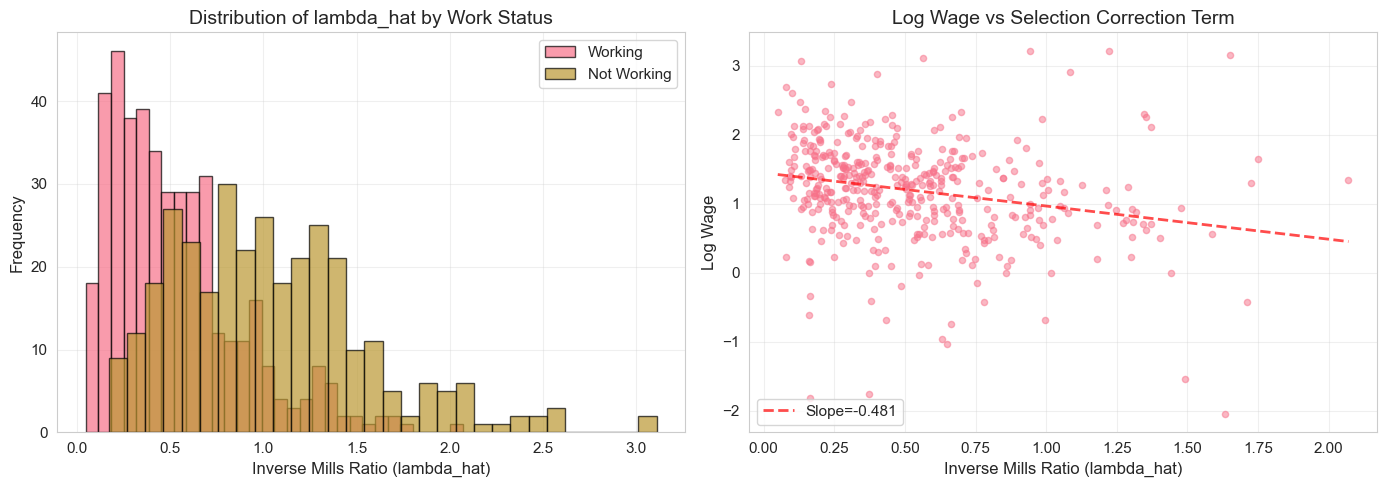


INTERPRETATION:
Panel A: lambda_hat is higher for working women (higher selection pressure)
Panel B: Correlation between lambda_hat and wages shows selection effect


In [34]:
# Visualize selection bias
print("\nVISUALIZING SELECTION BIAS")
print("=" * 70)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel A: Inverse Mills ratio by work status
working = mroz[mroz["inlf"] == 1]["inv_mills"]
not_working = mroz[mroz["inlf"] == 0]["inv_mills"]

axes[0].hist(working, bins=30, alpha=0.7, label="Working", edgecolor="black")
axes[0].hist(not_working, bins=30, alpha=0.7, label="Not Working", edgecolor="black")
axes[0].set_xlabel("Inverse Mills Ratio (lambda_hat)")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of lambda_hat by Work Status")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Panel B: Predicted wages vs inverse Mills ratio (working women)
working_data = mroz[mroz["inlf"] == 1].copy()
axes[1].scatter(working_data["inv_mills"], working_data["lwage"], alpha=0.5, s=20)
axes[1].set_xlabel("Inverse Mills Ratio (lambda_hat)")
axes[1].set_ylabel("Log Wage")
axes[1].set_title("Log Wage vs Selection Correction Term")
axes[1].grid(True, alpha=0.3)

# Add regression line
z = np.polyfit(working_data["inv_mills"], working_data["lwage"], 1)
p = np.poly1d(z)
x_line = np.linspace(
    working_data["inv_mills"].min(), working_data["inv_mills"].max(), 100
)
axes[1].plot(
    x_line, p(x_line), "r--", linewidth=2, alpha=0.7, label=f"Slope={z[0]:.3f}"
)
axes[1].legend()

plt.tight_layout()
plt.show()

print("\nINTERPRETATION:")
print("Panel A: lambda_hat is higher for working women (higher selection pressure)")
print("Panel B: Correlation between lambda_hat and wages shows selection effect")

## Summary

This chapter introduced **limited dependent variable models** for outcomes that are restricted in some way.

### Key Models and Applications

1. **Binary Response (Logit/Probit)**:
   - Outcome: 0 or 1
   - Models: Linear probability, logit, probit
   - Interpretation: Marginal effects (not coefficients!)
   - Applications: Labor force participation, college attendance, loan default

2. **Fractional Response**:
   - Outcome: Proportion in (0, 1)
   - Model: Fractional logit (quasi-MLE)
   - Applications: Savings rate, portfolio shares

3. **Count Data (Poisson)**:
   - Outcome: Non-negative integer
   - Models: Poisson, quasi-Poisson (overdispersion)
   - Interpretation: Semi-elasticities
   - Applications: Number of arrests, patents, doctor visits

4. **Corner Solution (Tobit)**:
   - Outcome: Many zeros, positive continuous values
   - Model: Tobit (Type I censored regression)
   - Interpretation: Effects on latent variable and observed variable differ
   - Applications: Hours worked, charitable contributions, R&D spending

5. **Censored/Truncated Regression**:
   - **Censored**: Observe all individuals, some outcomes censored
   - **Truncated**: Only observe individuals meeting some condition
   - Applications: Duration models, survival analysis

6. **Sample Selection (Heckman)**:
   - Problem: Sample is non-randomly selected
   - Solution: Two-step procedure with inverse Mills ratio
   - Applications: Wages (only observe workers), firm performance (only observe survivors)

### Key Principles

**Don't use OLS for limited dependent variables!**

Why?
- Predictions can be outside feasible range
- Heteroskedasticity is inherent
- Effects are nonlinear
- Inefficient or biased estimates

**Use specialized models** that respect the nature of the outcome:

| Outcome Type | Model | Key Feature |
|---|---|---|
| Binary (0/1) | Logit/Probit | Probabilities in [0, 1] |
| Fraction (0-1) | Fractional logit | Handles corner solutions |
| Count (0, 1, 2, ...) | Poisson | Non-negative integers |
| Corner (many 0s, positive) | Tobit | Two-part model |
| Censored | Censored regression | Explicit censoring |
| Truncated | Truncated regression | Sample selection |
| Non-random sample | Heckman | Inverse Mills ratio |

### Interpretation Guidelines

1. **Binary models**: Report **marginal effects**, not coefficients
2. **Poisson**: Coefficients are **semi-elasticities** (percentage changes)
3. **Tobit**: Distinguish effects on **latent** vs **observed** variable
4. **Heckman**: Test significance of **inverse Mills ratio** (selection bias)

### Practical Recommendations

YES **Always check**:
- Nature of dependent variable (binary, count, corner, etc.)
- Distribution of outcomes (many zeros? censoring?)
- Sample selection issues (non-random sample?)

YES **Use robust standard errors**:
- Heteroskedasticity is inherent in limited dependent variable models
- Always use HC or clustered standard errors

YES **Report marginal effects**:
- Coefficients alone are hard to interpret
- Calculate average marginal effects (AME) or marginal effects at the mean (MEM)

YES **Check predictions**:
- Ensure predictions are in feasible range
- Plot fitted vs actual values

NO **Don't use**:
- OLS for binary outcomes (use logit/probit)
- OLS for count data (use Poisson)
- OLS on selected sample without correction (use Heckman)

**Next Steps**: Chapter 18 covers **advanced time series topics** including cointegration, vector autoregressions, and forecasting!

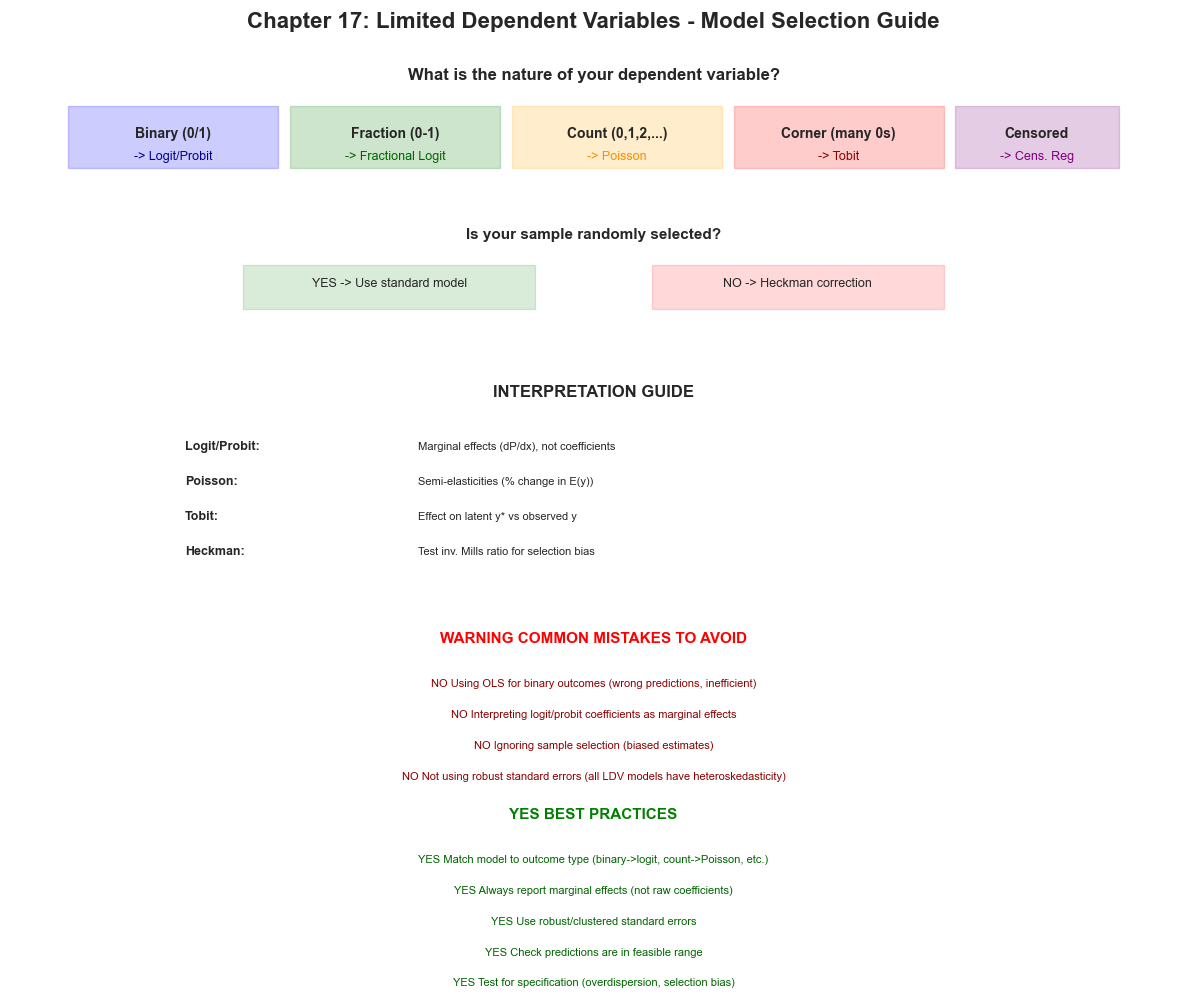

In [35]:
# Visual summary
fig, ax = plt.subplots(figsize=(12, 10))
ax.axis("off")

# Title
ax.text(
    0.5,
    0.98,
    "Chapter 17: Limited Dependent Variables - Model Selection Guide",
    ha="center",
    fontsize=16,
    fontweight="bold",
)

# Decision tree
y_start = 0.92
spacing = 0.09

# Question 1: Nature of y
ax.text(
    0.5,
    y_start,
    "What is the nature of your dependent variable?",
    ha="center",
    fontsize=12,
    fontweight="bold",
)

# Binary
ax.add_patch(
    plt.Rectangle(
        (0.05, y_start - 0.10), 0.18, 0.07, fill=True, alpha=0.2, color="blue"
    )
)
ax.text(
    0.14, y_start - 0.065, "Binary (0/1)", ha="center", fontsize=10, fontweight="bold"
)
ax.text(
    0.14, y_start - 0.09, "-> Logit/Probit", ha="center", fontsize=9, color="darkblue"
)

# Fraction
ax.add_patch(
    plt.Rectangle(
        (0.24, y_start - 0.10), 0.18, 0.07, fill=True, alpha=0.2, color="green"
    )
)
ax.text(
    0.33, y_start - 0.065, "Fraction (0-1)", ha="center", fontsize=10, fontweight="bold"
)
ax.text(
    0.33,
    y_start - 0.09,
    "-> Fractional Logit",
    ha="center",
    fontsize=9,
    color="darkgreen",
)

# Count
ax.add_patch(
    plt.Rectangle(
        (0.43, y_start - 0.10), 0.18, 0.07, fill=True, alpha=0.2, color="orange"
    )
)
ax.text(
    0.52,
    y_start - 0.065,
    "Count (0,1,2,...)",
    ha="center",
    fontsize=10,
    fontweight="bold",
)
ax.text(0.52, y_start - 0.09, "-> Poisson", ha="center", fontsize=9, color="darkorange")

# Corner
ax.add_patch(
    plt.Rectangle((0.62, y_start - 0.10), 0.18, 0.07, fill=True, alpha=0.2, color="red")
)
ax.text(
    0.71,
    y_start - 0.065,
    "Corner (many 0s)",
    ha="center",
    fontsize=10,
    fontweight="bold",
)
ax.text(0.71, y_start - 0.09, "-> Tobit", ha="center", fontsize=9, color="darkred")

# Censored/truncated
ax.add_patch(
    plt.Rectangle(
        (0.81, y_start - 0.10), 0.14, 0.07, fill=True, alpha=0.2, color="purple"
    )
)
ax.text(0.88, y_start - 0.065, "Censored", ha="center", fontsize=10, fontweight="bold")
ax.text(0.88, y_start - 0.09, "-> Cens. Reg", ha="center", fontsize=9, color="purple")

# Question 2: Sample selection
y_select = y_start - 0.18
ax.text(
    0.5,
    y_select,
    "Is your sample randomly selected?",
    ha="center",
    fontsize=11,
    fontweight="bold",
)

ax.add_patch(
    plt.Rectangle(
        (0.2, y_select - 0.08), 0.25, 0.05, fill=True, alpha=0.15, color="green"
    )
)
ax.text(0.325, y_select - 0.055, "YES -> Use standard model", ha="center", fontsize=9)

ax.add_patch(
    plt.Rectangle(
        (0.55, y_select - 0.08), 0.25, 0.05, fill=True, alpha=0.15, color="red"
    )
)
ax.text(0.675, y_select - 0.055, "NO -> Heckman correction", ha="center", fontsize=9)

# Interpretation guide
y_interp = y_select - 0.18
ax.text(
    0.5, y_interp, "INTERPRETATION GUIDE", ha="center", fontsize=12, fontweight="bold"
)

interp_items = [
    ("Logit/Probit", "Marginal effects (dP/dx), not coefficients"),
    ("Poisson", "Semi-elasticities (% change in E(y))"),
    ("Tobit", "Effect on latent y* vs observed y"),
    ("Heckman", "Test inv. Mills ratio for selection bias"),
]

y_pos = y_interp - 0.06
for model, interpretation in interp_items:
    ax.text(0.15, y_pos, f"{model}:", ha="left", fontsize=9, fontweight="bold")
    ax.text(0.35, y_pos, interpretation, ha="left", fontsize=8)
    y_pos -= 0.04

# Common mistakes
y_mistakes = y_interp - 0.28
ax.text(
    0.5,
    y_mistakes,
    "WARNING COMMON MISTAKES TO AVOID",
    ha="center",
    fontsize=11,
    fontweight="bold",
    color="red",
)

mistakes = [
    "NO Using OLS for binary outcomes (wrong predictions, inefficient)",
    "NO Interpreting logit/probit coefficients as marginal effects",
    "NO Ignoring sample selection (biased estimates)",
    "NO Not using robust standard errors (all LDV models have heteroskedasticity)",
]

y_pos = y_mistakes - 0.05
for mistake in mistakes:
    ax.text(0.5, y_pos, mistake, ha="center", fontsize=8, color="darkred")
    y_pos -= 0.035

# Best practices
y_best = y_mistakes - 0.20
ax.text(
    0.5,
    y_best,
    "YES BEST PRACTICES",
    ha="center",
    fontsize=11,
    fontweight="bold",
    color="green",
)

practices = [
    "YES Match model to outcome type (binary->logit, count->Poisson, etc.)",
    "YES Always report marginal effects (not raw coefficients)",
    "YES Use robust/clustered standard errors",
    "YES Check predictions are in feasible range",
    "YES Test for specification (overdispersion, selection bias)",
]

y_pos = y_best - 0.05
for practice in practices:
    ax.text(0.5, y_pos, practice, ha="center", fontsize=8, color="darkgreen")
    y_pos -= 0.035

plt.tight_layout()
plt.show()